(frailty_models)=
# Frailty and Survival Regression Models

:::{post} January, 2023
:tags: frailty models, survival analysis, competing risks
:category: intermediate, reference
:author: Nathaniel Forde
:::

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
from matplotlib import cm
from scipy.stats import fisk , weibull_min

In [3]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(42)

The full generality and range of application for survival analysis is masked. It's obscured by loaded semantics and living under the inevitable regime of time. Survival analysis broadly construed is not about you, it's not even necessarily about health.  

But it requires an extra step in abstraction to move from the medical context to seeing that time-to-event data is everywhere! Every task which has an implicit clock, every goal with a finish line, every reaper owed a toll - these are sources of time-to-event data. 

We will demonstrate how the concepts of survival based regression analysis, traditionally deployed in the medical setting, can be fruitfully applied to HR data and business process analysis. In particular, we'll look at the question of time-to-attrition in an employee life-cylce data. We will model this phenomena as a function of employee survey responses earlier in the year. 

### Survival Regression Models

The emphasis here is on the generality of the framework. We are describing the trajectory of state-transitions within time. Anywhere speed or efficiency matters, it is important to understand the inputs to time-to-event trajectories. This is the benefit of survival analysis - clearly articulated models which quantify the impact of demographic characteristics and treatment effects (in terms of speed) on the probability of state-transition. 

We will see two varieties of regression modelling with respect to time-to-event data: (1) Cox's Proportional Hazard approach and (2) the Accelerated Failure time models. Both models enable the analyst to combine and assess the impacts of different covariates on the survival time outcomes, but each does so in a slightly different manner. 

We will also show a hierarchical variant of survival modelling called frailty modelling, where we estimate the survival function using regression but allow for the inclusion of individual or groups specific "frailty" terms. These are a multiplicative factor applied to the estimation routine of an individual's survival curve allowing us to capture some of the unexplained heterogeneity in the population. 

## Exploration of the Data

Our data is drawn from a HR themed example discussed in Keith McNulty's [Handbook of Regression Modelling in People Analytics](https://peopleanalytics-regression-book.org/survival.html). The data describes survey responses to questions about job satisfaction and the respondents intention to seek employment elsewhere. Additionally the data has broad "demographic" information of the respondent and crucially indications of whether they `left` employment at the company and on which `month` after the survey we still have record of them at the company. 

It's important to note that this kind of data is invariably censored data, since it is always pulled at a point in time. So there are some people for whom which we do not see an exit event. They may never leave the company, but importantly at the point of measurement we simply do not know if they will leave tomorrow... so the data is meaningfully censored at the point in time of measurement, so our modelling strategy needs to account for how that changes the proababilitie in question. 

In [740]:
retention_df = pd.read_csv('../data/time_to_attrition.csv')

dummies = pd.concat([pd.get_dummies(retention_df['gender'], drop_first=True),
pd.get_dummies(retention_df['level'], drop_first=True),
pd.get_dummies(retention_df['field'], drop_first=True), 
], axis=1).rename({'M': 'Male'}, axis=1)

retention_df = pd.concat([retention_df, dummies], axis=1)
retention_df.head()

gender                   field   level  sentiment  intention  left  month  \
0      M       Public/Government    High          3          8     1      1   
1      F                 Finance     Low          8          4     0     12   
2      M  Education and Training  Medium          7          7     1      5   
3      M                 Finance     Low          8          4     0     12   
4      M                 Finance    High          7          6     1      1   

   Male  Low  Medium  Finance  Health  Law  Public/Government  Sales/Marketing  
0     1    0       0        0       0    0                  1                0  
1     0    1       0        1       0    0                  0                0  
2     1    0       1        0       0    0                  0                0  
3     1    1       0        1       0    0                  0                0  
4     1    0       0        1       0    0                  0                0

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/lifelines/plotting.py:964: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


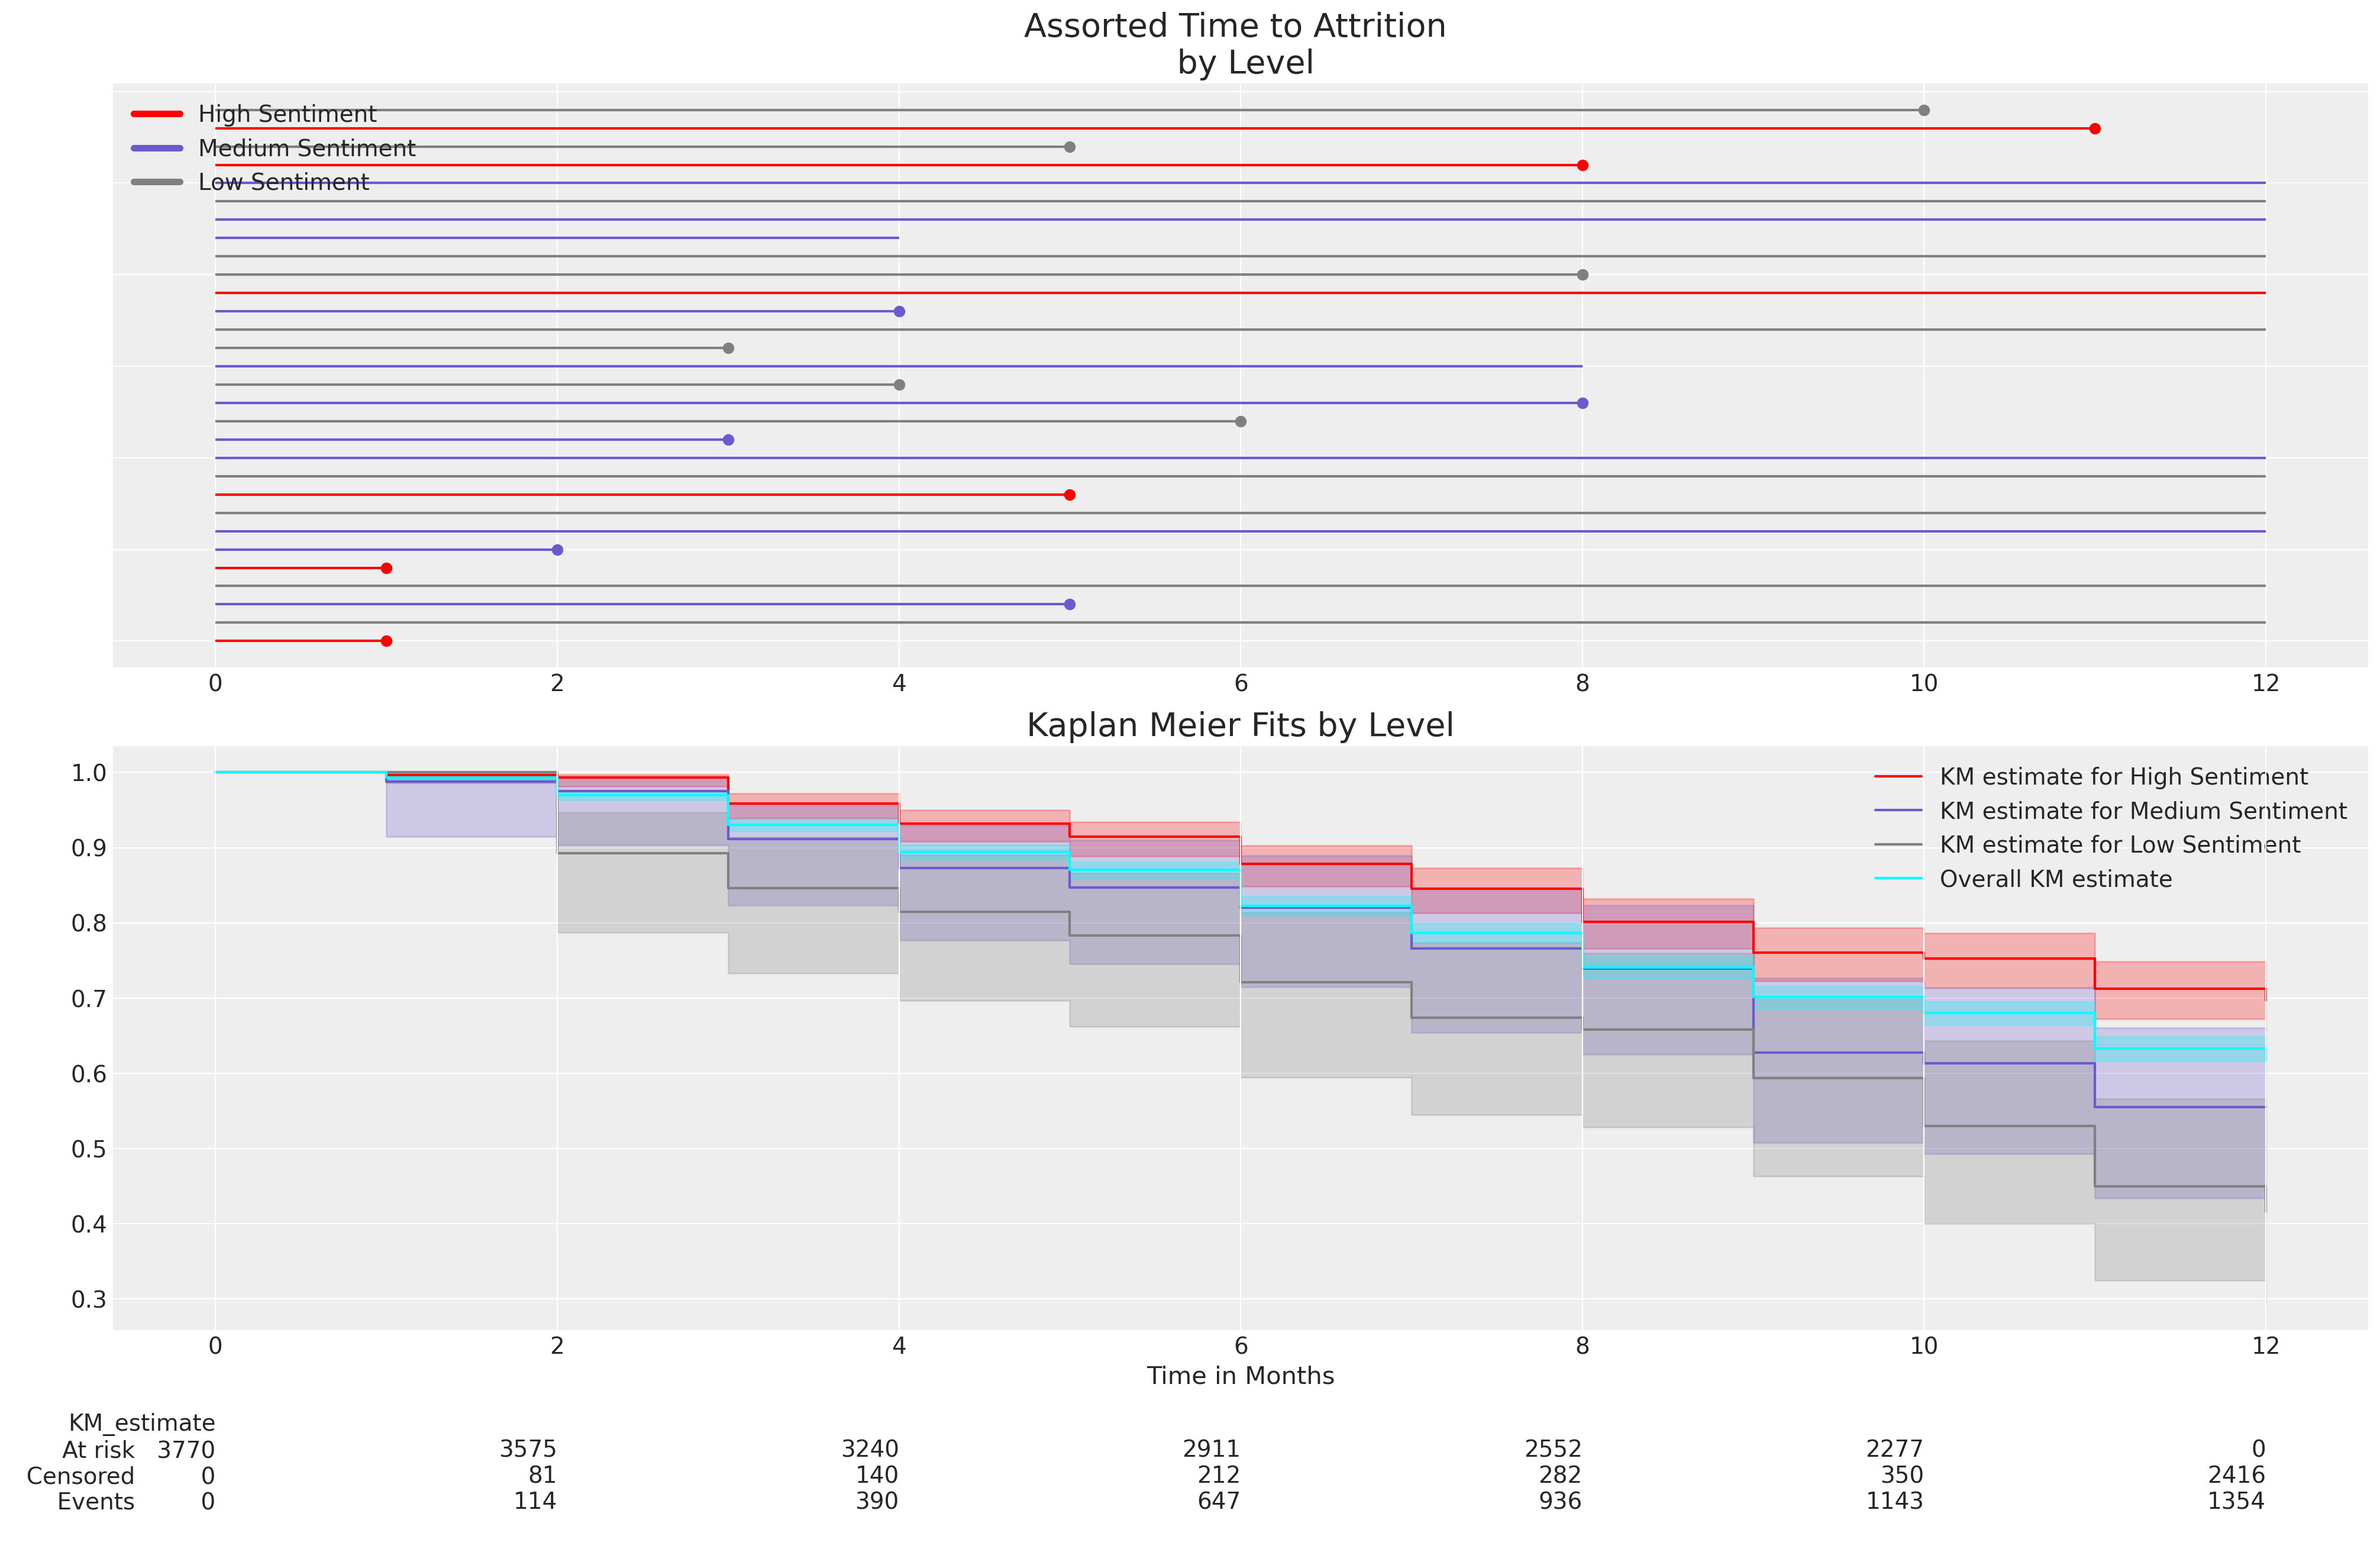

In [741]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(retention_df['month'], event_observed=retention_df['left'])
kmf_hi = KaplanMeierFitter()
kmf_hi.fit(retention_df[retention_df['sentiment']==10]['month'], event_observed=retention_df[retention_df['sentiment']==10]['left'])
kmf_mid = KaplanMeierFitter()
kmf_mid.fit(retention_df[retention_df['sentiment']==5]['month'], event_observed=retention_df[retention_df['sentiment']==5]['left'])
kmf_low = KaplanMeierFitter()
kmf_low.fit(retention_df[retention_df['sentiment']==2]['month'], event_observed=retention_df[retention_df['sentiment']==2]['left'])

fig, axs = plt.subplots(2,1, figsize=(20, 13))
axs = axs.flatten()
ax = axs[0]
for i in retention_df.index.unique()[0:30]:
    temp = retention_df[retention_df.index == i]
    event = temp['left'].max() == 1
    level = temp['level'].unique()
    duration = temp['month'].max()
    color = np.where(level == 'High', 'red', np.where(level == 'Medium', 'slateblue', 'grey'))
    ax.hlines(i, 0, duration, color=color)
    if event: 
        ax.scatter(duration, i, color=color)
ax.set_title("Assorted Time to Attrition \n by Level", fontsize=20)
ax.set_yticklabels([])
from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='slateblue', lw=4),
                Line2D([0], [0], color='grey', lw=4)]

ax.legend(custom_lines, ['High Sentiment', 'Medium Sentiment', 'Low Sentiment'])


kmf_hi.plot_survival_function(ax=axs[1], label='KM estimate for High Sentiment', color='red')
kmf_mid.plot_survival_function(ax=axs[1], label='KM estimate for Medium Sentiment', color='slateblue')
kmf_low.plot_survival_function(ax=axs[1], label='KM estimate for Low Sentiment', color='grey')
kmf.plot_survival_function(ax=axs[1], label='Overall KM estimate', color='cyan', at_risk_counts=True)
axs[1].set_xlabel("Time in Months")
axs[1].set_title("Kaplan Meier Fits by Level", fontsize=20);
    
    

## Data Preperation for Survival Regression

The idea behind Cox Proportional Hazard regression models is, put crudely, to treat the temporal component of risk seriously. We imagine a latent baseline hazard of occurence over the time-interval. This term is often denoted:

$$ \lambda_{0}(t)$$

It is combined multiplicatively in the Cox Regression: 

$$ \lambda_{0}(t) \cdot e^{\beta_{1}X_{1} + \beta_{2}X_{2}... \beta_{k}X_{k}} $$

and represents the baseline hazard at each point in time when the predictor variables are set at their baseline/reference levels. In our case we are looking at data with granularity of monthly entries. So we need to understand how the risk of attrition changes over the next 12 months subsequent to the date of the annual survey. 

These models can be estimated using the approach of Bayesian estimation outlined by Austin Rochford in {ref}`survival_analysis`


In [7]:
interval_length = 1
interval_bounds = np.arange(0, retention_df.month.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)
intervals

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

We then arrange our data into a structure to show if and when each individual in the data set experienced an event of attrition. 

In [8]:
intervals = np.arange(12)
n_employees = retention_df.shape[0]
n_intervals =len(intervals)
last_period = np.floor((retention_df.month - 0.01) / interval_length).astype(int)
employees = np.arange(n_employees)
quit = np.zeros((n_employees, n_intervals))
quit[employees, last_period] = retention_df['left']

pd.DataFrame(quit)

0    1    2    3    4    5    6    7    8    9    10   11
0     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
3765  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3766  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
3767  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
3768  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3769  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[3770 rows x 12 columns]

As outlined in {ref}`Reliability Statistics and Predictive Calibration` the hazard function, the cumulative density function and the survival function of a failure time distribution are all intimately related. In particular each of these can be described in relation to the set of individual at risk at any given time in the sequence. The pool of those individuals at risk changes over time as people experience events of attrition. This changes the conditional hazard ovr time. To account for this in our estimation strategy we need to configure our data to flag who is at risk and when. 

In [9]:
exposure = np.greater_equal.outer(retention_df.month.to_numpy(), interval_bounds[:-2]) * interval_length
exposure[employees, last_period] = retention_df.month - interval_bounds[last_period]
pd.DataFrame(exposure)

0   1   2   3   4   5   6   7   8   9   10  11
0      1   1   0   0   0   0   0   0   0   0   0   0
1      1   1   1   1   1   1   1   1   1   1   1   1
2      1   1   1   1   1   1   0   0   0   0   0   0
3      1   1   1   1   1   1   1   1   1   1   1   1
4      1   1   0   0   0   0   0   0   0   0   0   0
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
3765   1   1   1   1   1   1   1   1   1   1   1   1
3766   1   1   1   1   1   1   1   1   1   0   0   0
3767   1   1   1   1   1   1   1   1   1   0   0   0
3768   1   1   1   1   1   1   1   1   1   1   1   1
3769   1   1   1   1   1   1   1   1   1   1   1   1

[3770 rows x 12 columns]

## Fit Basic Cox Model with Fixed Effects

In [787]:

preds = ['sentiment', 'Male', 'Low', 'Medium', 'Finance', 'Health', 'Law', 'Public/Government', 'Sales/Marketing']
preds2 = ['sentiment', 'intention', 'Male', 'Low', 'Medium', 'Finance', 'Health', 'Law', 'Public/Government', 'Sales/Marketing']

def make_coxph(preds):
    coords = {"intervals": intervals, 'preds': preds}

    with pm.Model(coords=coords) as base_model:
        X_data = pm.MutableData('X_data_obs', retention_df[preds])
        lambda0 = pm.Gamma("lambda0", 0.01, 0.01, dims="intervals")

        beta = pm.Normal("beta", 0, sigma=1, dims ='preds')
        lambda_ = pm.Deterministic("lambda_", pt.outer(pt.exp( pm.math.dot(beta, X_data.T)), lambda0))
    
        mu = pm.Deterministic("mu", exposure*lambda_)

        obs = pm.Poisson("obs", mu, observed=quit)
        base_idata = pm.sample_prior_predictive()
        base_idata.extend(pm.sample())
    
    return base_idata, base_model
    
base_idata, base_model = make_coxph(preds)
base_intention_idata, base_intention_model = make_coxph(preds2)

Sampling: [beta, lambda0, obs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda0, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [beta, lambda0, obs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda0, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.


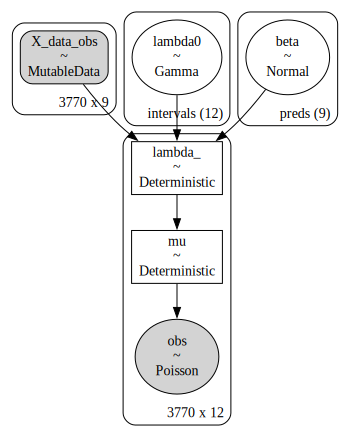

In [788]:
pm.model_to_graphviz(base_model)

## Predicting Marginal Effects of CoxPH regression

In [789]:
def cum_hazard(hazard):
    return hazard.cumsum(dim='intervals')


def survival(hazard):
    return np.exp(-cum_hazard(hazard))


def get_mean(trace):
    return trace.mean(("draw", "chain"))

In [814]:
def extract_individual_hazard(idata, i, retention_df):
    hazard_base_m1 = idata['posterior']['lambda0']
    beta = idata.posterior['beta']
    full_hazard_idata = hazard_base_m1 * np.exp(
                                        beta.sel(preds='sentiment')*retention_df.iloc[i]['sentiment'] + 
                                        beta.sel(preds='Male')*retention_df.iloc[i]['Male'] +
                                        beta.sel(preds='Low')*retention_df.iloc[i]['Low'] +  
                                        beta.sel(preds='Medium')*retention_df.iloc[i]['Medium'] +
                                        beta.sel(preds='Finance')*retention_df.iloc[i]['Finance'] +
                                        beta.sel(preds='Health')*retention_df.iloc[i]['Health'] +
                                        beta.sel(preds='Law')*retention_df.iloc[i]['Law'] +
                                        beta.sel(preds='Public/Government')*retention_df.iloc[i]['Public/Government'] +
                                        beta.sel(preds='Sales/Marketing')*retention_df.iloc[i]['Sales/Marketing'] 
                                        )

    cum_haz_idata = cum_hazard(full_hazard_idata)
    survival_idata = survival(full_hazard_idata)
    return full_hazard_idata, cum_haz_idata, survival_idata, hazard_base_m1


def plot_individuals(retention_df, idata, individuals=[1, 300, 700]): 
    fig, axs = plt.subplots(1, 2, figsize=(20, 7))
    axs = axs.flatten()
    for i in individuals:
        haz_idata, cum_haz_idata, survival_idata, base_hazard = extract_individual_hazard(idata, i, retention_df)
        axs[0].plot(get_mean(survival_idata), label=f'individual_{i}')
        az.plot_hdi(range(12),survival_idata, ax=axs[0], fill_kwargs={'color': 'slateblue'})
        axs[1].plot(get_mean(cum_haz_idata), label=f'individual_{i}')
        az.plot_hdi(range(12),cum_haz_idata, ax=axs[1], fill_kwargs={'color': 'grey'})
        axs[0].set_title("Individual Survival Functions", fontsize=15)
        axs[1].set_title("Individual Cumulative Hazard Functions", fontsize=15)
    az.plot_hdi(range(12), survival(base_hazard), color='lightblue', ax=axs[0], fill_kwargs={"label": "Baseline Survival"})
    axs[0].plot(get_mean(survival(base_hazard)), color='black', linestyle='--', label='Expected Baseline Survival')
    az.plot_hdi(range(12), cum_hazard(base_hazard), color='lightblue', ax=axs[1], fill_kwargs={"label": "Baseline Hazard"})
    axs[1].plot(get_mean(cum_hazard(base_hazard)), color='black', linestyle='--', label='Expected Baseline Hazard')
    axs[0].legend()
    axs[1].legend()


test_df = pd.DataFrame(np.zeros((3, 15)), columns=retention_df.columns)
test_df['sentiment'] = [1, 5, 10]
test_df['Medium'] = [0, 0, 0]
test_df['Finance'] = [0, 0, 0]
test_df['M'] = [1, 1, 1]
test_df

gender  field  level  sentiment  intention  left  month  Male  Low  Medium  \
0     0.0    0.0    0.0          1        0.0   0.0    0.0   0.0  0.0       0   
1     0.0    0.0    0.0          5        0.0   0.0    0.0   0.0  0.0       0   
2     0.0    0.0    0.0         10        0.0   0.0    0.0   0.0  0.0       0   

   Finance  Health  Law  Public/Government  Sales/Marketing  M  
0        0     0.0  0.0                0.0              0.0  1  
1        0     0.0  0.0                0.0              0.0  1  
2        0     0.0  0.0                0.0              0.0  1

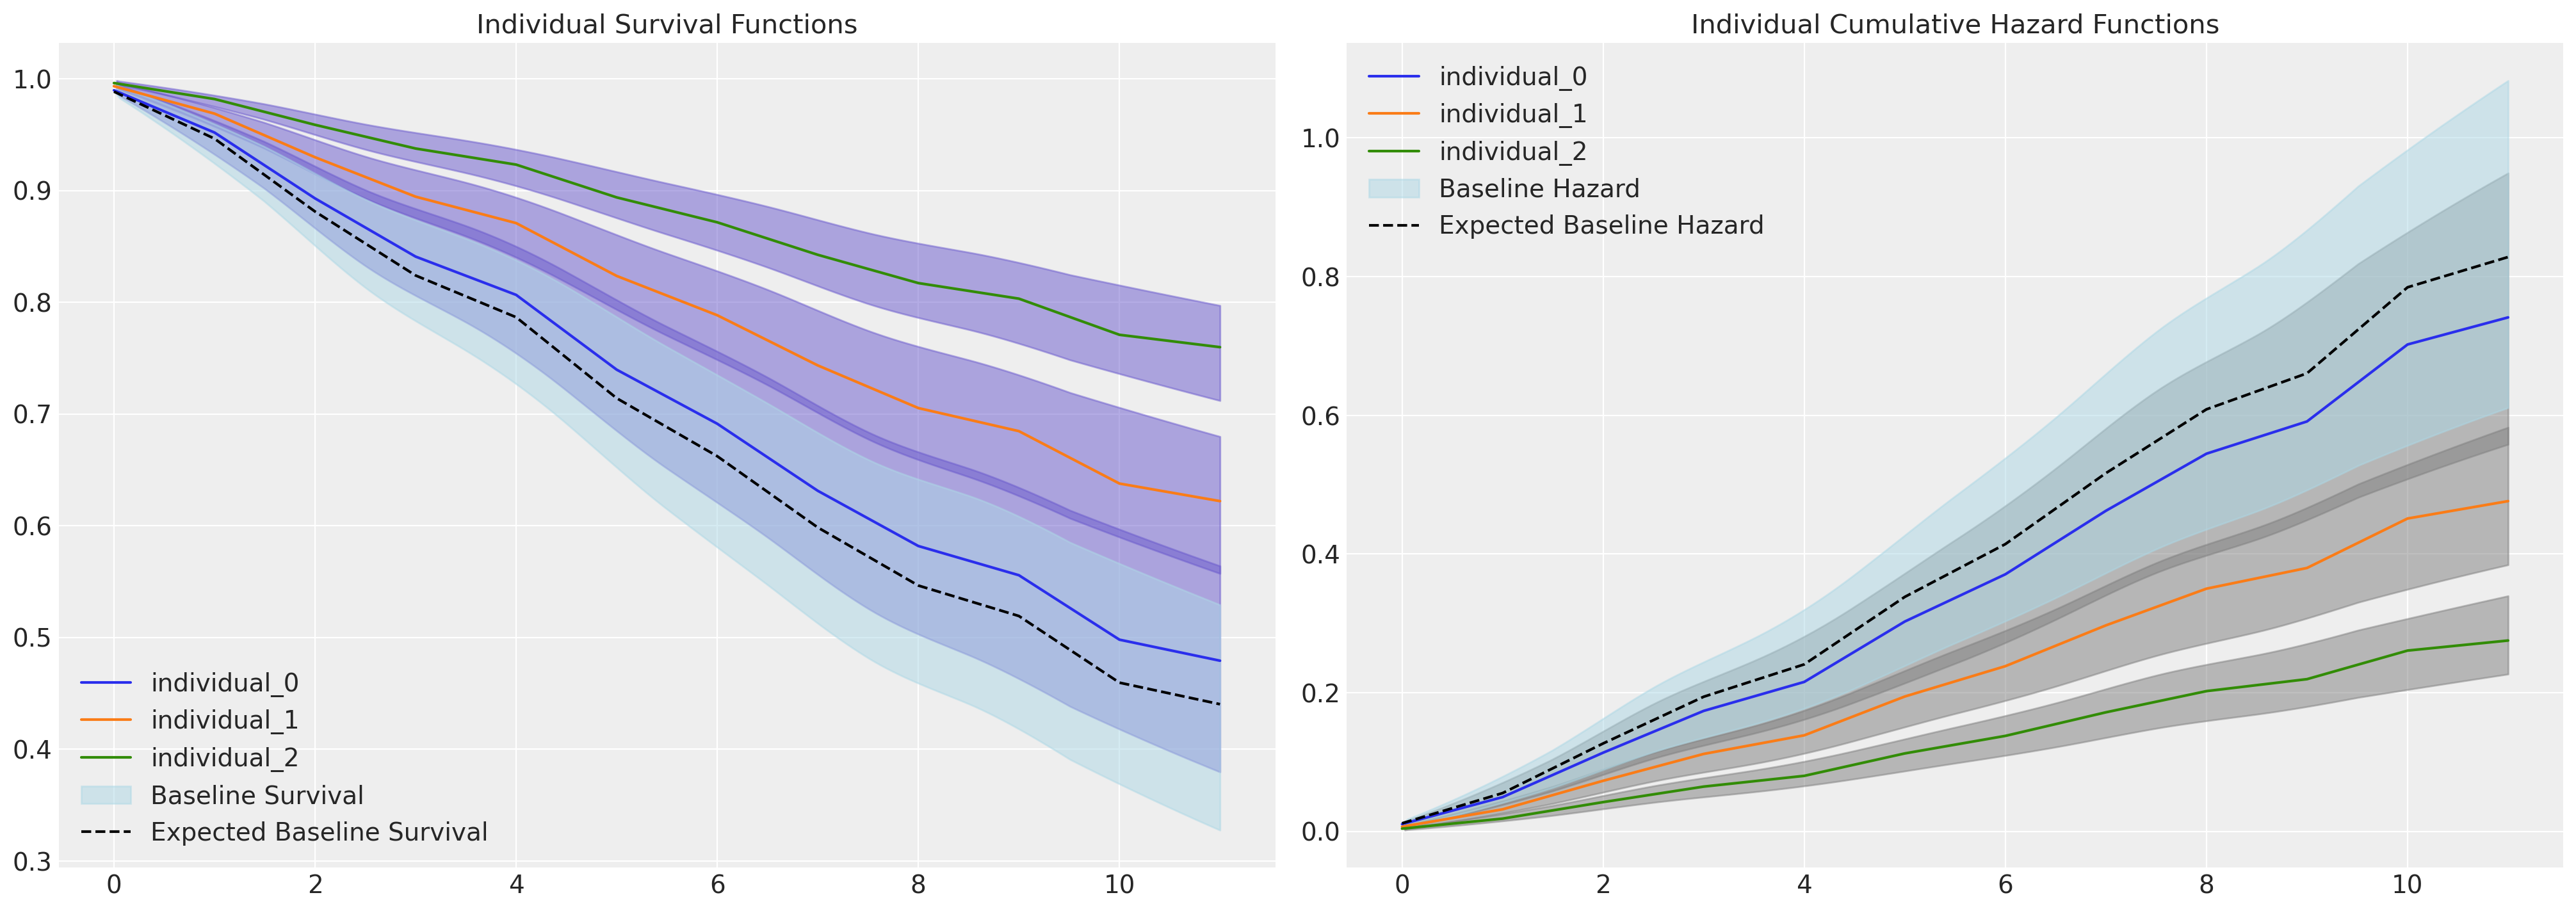

In [815]:
plot_individuals(test_df, base_idata, [0, 1, 2])

In [810]:
def create_predictions(retention_df, idata):
    cum_haz = {}
    surv = {}
    for i in range(len(retention_df)):
        haz_idata, cum_haz_idata, survival_idata, base_hazard = extract_individual_hazard(idata, i, retention_df)
        cum_haz[i] = get_mean(cum_haz_idata)
        surv[i] = get_mean(survival_idata)
    cum_haz = pd.DataFrame(cum_haz)
    surv = pd.DataFrame(surv)
    return cum_haz, surv

cum_haz_df, surv_df = create_predictions(retention_df, base_idata)
surv_df

0         1         2         3         4         5         6     \
0   0.991189  0.993273  0.993995  0.993530  0.993697  0.990992  0.994617   
1   0.958728  0.968356  0.971702  0.969542  0.970331  0.957811  0.974602   
2   0.907702  0.928773  0.936155  0.931390  0.933130  0.905717  0.942587   
3   0.862209  0.893024  0.903912  0.896880  0.899445  0.859366  0.913439   
4   0.832056  0.869058  0.882229  0.873718  0.876826  0.828668  0.893778   
5   0.772573  0.821149  0.838676  0.827330  0.831485  0.768200  0.854130   
6   0.729080  0.785530  0.806128  0.792779  0.797675  0.724050  0.824360   
7   0.674481  0.740074  0.764351  0.748593  0.754394  0.668714  0.785964   
8   0.628941  0.701466  0.728663  0.710983  0.717509  0.622658  0.752993   
9   0.604625  0.680571  0.709258  0.690595  0.697491  0.598103  0.734995   
10  0.550348  0.633160  0.664993  0.644240  0.651937  0.543376  0.693743   
11  0.532439  0.617271  0.650081  0.628675  0.636622  0.525349  0.679783   

        7         8         9     ...      3760      3761      3762      3763  \
0   0.992783  0.994320  0.993496  ...  0.993653  0.995499  0.990606  0.992783   
1   0.966078  0.973224  0.969385  ...  0.970123  0.978727  0.956057  0.966078   
2   0.923758  0.939538  0.931081  ...  0.932672  0.951785  0.901883  0.923758   
3   0.885652  0.908916  0.896457  ...  0.898775  0.927124  0.853767  0.885652   
4   0.860170  0.888300  0.873229  ...  0.876016  0.910415  0.821959  0.860170   
5   0.809375  0.846810  0.826742  ...  0.830406  0.876544  0.759449  0.809375   
6   0.771753  0.815737  0.792157  ...  0.796414  0.850939  0.713931  0.771753   
7   0.723917  0.775758  0.747958  ...  0.752910  0.817695  0.657061  0.723917   
8   0.683456  0.741512  0.710373  ...  0.715847  0.788937  0.609864  0.683456   
9   0.661625  0.722857  0.690007  ...  0.695742  0.773151  0.584752  0.661625   
10  0.612270  0.680209  0.643749  ...  0.649991  0.736733  0.528934  0.612270   
11  0.595789  0.665806  0.628224  ...  0.634617  0.724330  0.510599  0.595789   

        3764      3765      3766      3767      3768      3769  
0   0.993209  0.995243  0.992783  0.989977  0.995907  0.994171  
1   0.968045  0.977539  0.966078  0.953147  0.980642  0.972522  
2   0.928108  0.949139  0.923758  0.895594  0.956075  0.937982  
3   0.892079  0.923184  0.885652  0.844651  0.933527  0.906615  
4   0.867943  0.905620  0.860170  0.811058  0.918226  0.885504  
5   0.819715  0.870074  0.809375  0.745267  0.887124  0.843051  
6   0.783898  0.843259  0.771753  0.697569  0.863550  0.811288  
7   0.738209  0.808521  0.723917  0.638232  0.832843  0.770459  
8   0.699446  0.778529  0.683456  0.589223  0.806185  0.735518  
9   0.678487  0.762095  0.661625  0.563246  0.791517  0.716505  
10  0.630968  0.724247  0.612270  0.505762  0.757578  0.673071  
11  0.615053  0.711380  0.595789  0.486960  0.745980  0.658417  

[12 rows x 3770 columns]

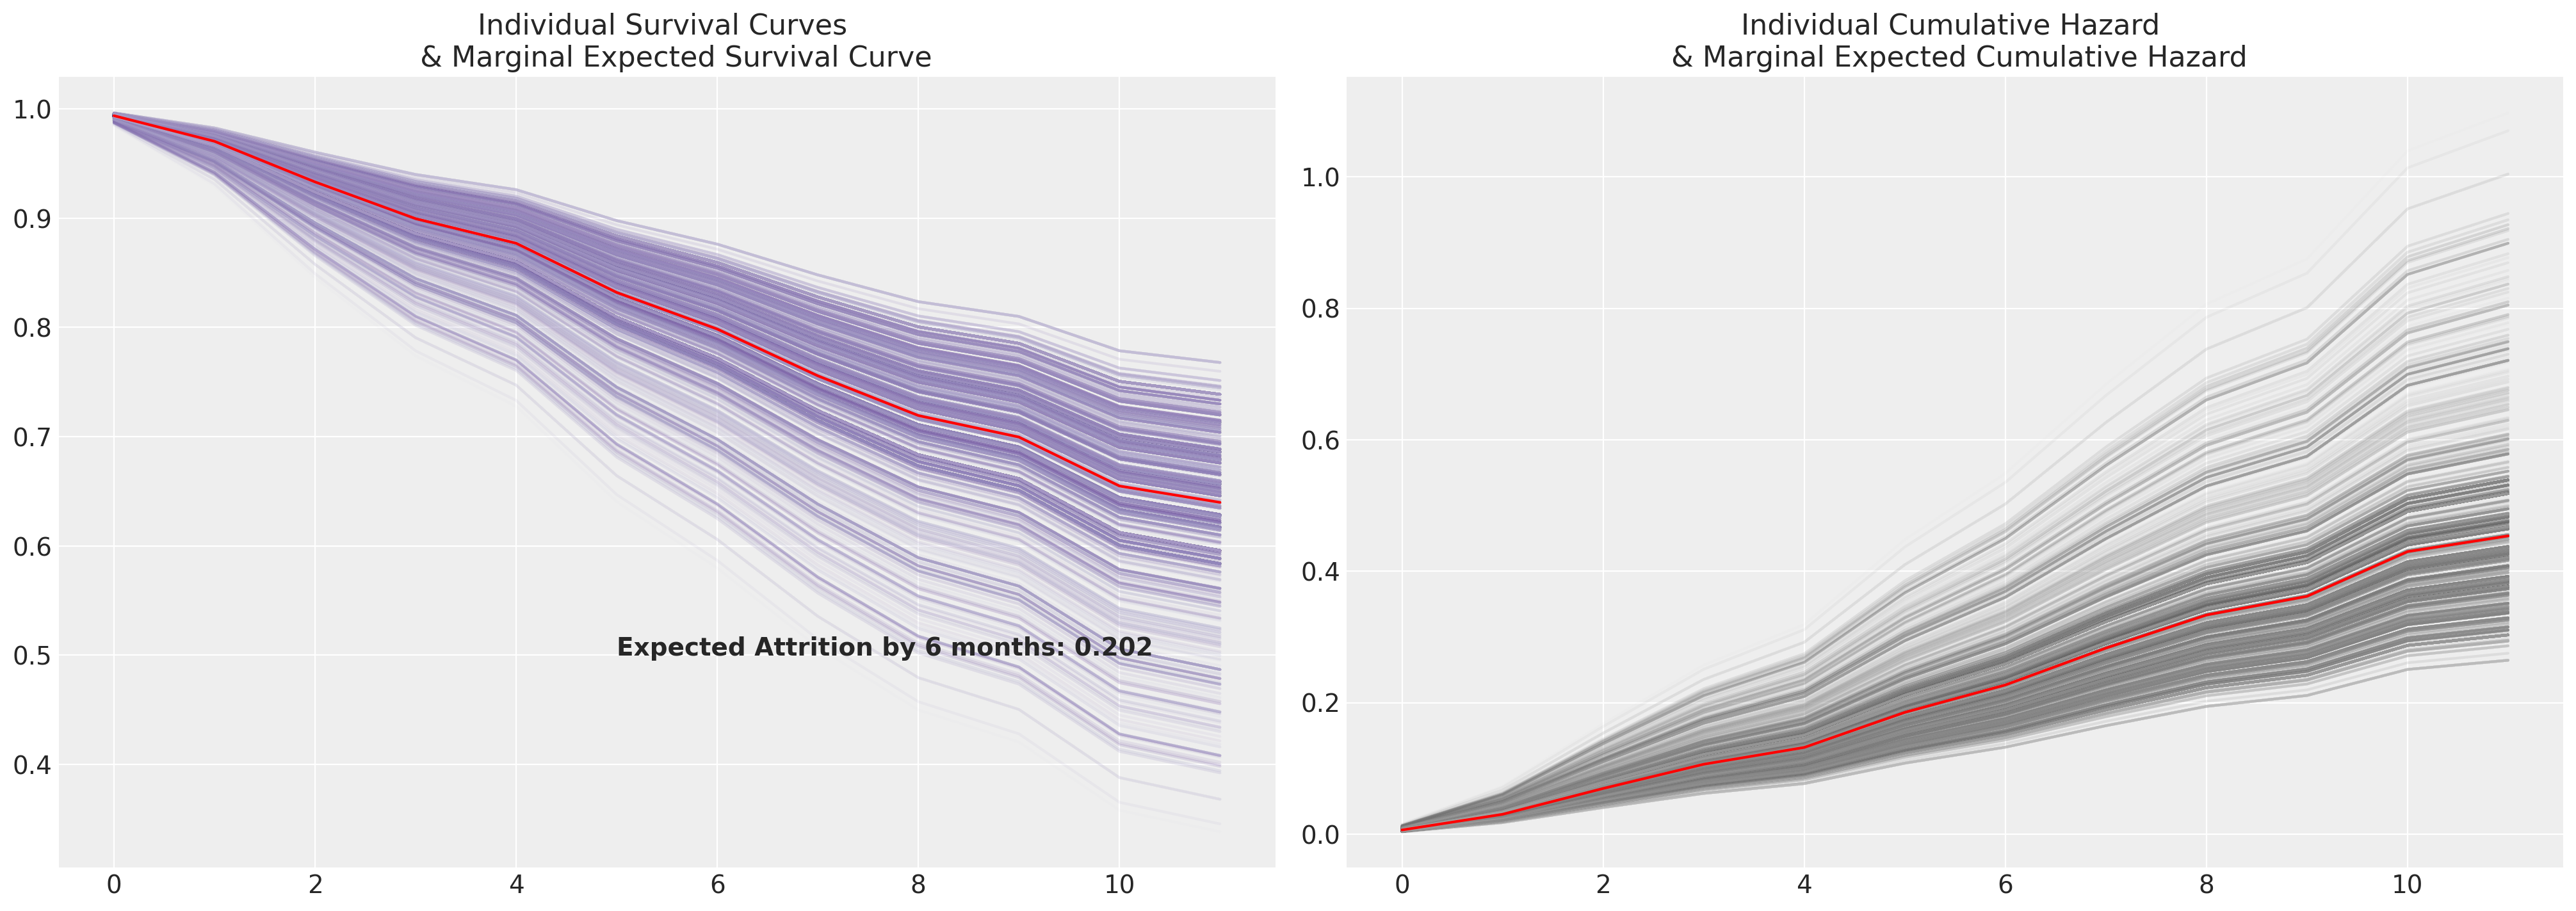

In [827]:
cm_subsection = np.linspace(0, 1, 120) 
colors_m = [cm.Purples(x) for x in cm_subsection]
colors = [cm.Greys(x) for x in cm_subsection]


fig, axs = plt.subplots(1, 2, figsize=(20, 7))
axs = axs.flatten()
cum_haz_df.plot(legend=False, color=colors, alpha=0.05, ax=axs[1])
axs[1].plot(cum_haz_df.mean(axis=1), color='red')
axs[1].set_title("Individual Cumulative Hazard \n & Marginal Expected Cumulative Hazard")

surv_df.plot(legend=False, color=colors_m, alpha=0.05, ax=axs[0])
axs[0].plot(surv_df.mean(axis=1), color='red');
axs[0].set_title("Individual Survival Curves \n  & Marginal Expected Survival Curve");
axs[0].annotate(f'Expected Attrition by 6 months: {np.round(1-surv_df.mean(axis=1).iloc[6], 3)}', (5, 0.5), 
                fontsize=14, fontweight='bold');

## Fit Model with Shared Frailty terms by Individual

In [746]:
frailty_idx, frailty_labels = pd.factorize(range(len(retention_df)))

def make_coxph_frailty(preds, factor):
    frailty_idx, frailty_labels = pd.factorize(factor)
    coords = {"intervals": intervals, 
          'preds': preds, 
          "frailty_id": frailty_labels}

    with pm.Model(coords=coords) as frailty_model:
        X_data = pm.MutableData('X_data_obs', retention_df[preds])
        lambda0 = pm.Gamma("lambda0", 0.01, 0.01, dims="intervals")
        frailty = pm.LogNormal('frailty', 0, 0.25, dims='frailty_id')
        
        
        beta = pm.Normal("beta", 0, sigma=1, dims ='preds')

        lambda_ = pm.Deterministic("lambda_", pt.outer(pt.exp(pm.math.dot(beta, X_data.T)), lambda0))
        lambda1 = pm.Deterministic('lambda1', frailty[frailty_idx, None]*lambda_)
        
        mu = pm.Deterministic("mu", exposure*lambda1)

        obs = pm.Poisson("obs", mu, observed=quit)
        frailty_idata = pm.sample_prior_predictive()
        frailty_idata.extend(pm.sample())

    return frailty_idata, frailty_model
frailty_idata, frailty_model = make_coxph_frailty(preds, range(len(retention_df)))
shared_frailty_idata, shared_frailty_model = make_coxph_frailty(preds, retention_df['field'])


Sampling: [beta, frailty, lambda0, obs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda0, frailty, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 103 seconds.
Sampling: [beta, frailty, lambda0, obs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda0, frailty, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 142 seconds.


## Accelerated Failure Time Model

In [628]:
coords = {"intervals": intervals, 
          'preds': ['sentiment','Male', 'Low', 'Medium', 
                    'Finance', 'Health', 'Law', 'Public/Government', 'Sales/Marketing']}

X = retention_df[['sentiment','M', 'Low', 'Medium', 
                    'Finance', 'Health', 'Law', 'Public/Government', 'Sales/Marketing']]
y = retention_df['month'].values
cens = retention_df.left.values == 0.0


def logistic_sf(y, μ, s):
    return 1.0 - pm.math.sigmoid((y - μ) / s)

def weibull_lccdf(x, alpha, beta):
    """Log complementary cdf of Weibull distribution."""
    return -((x / beta) ** alpha)


def make_aft(y, weibull=True):
    with pm.Model(coords=coords, check_bounds=False) as aft_model:
        X_data = pm.MutableData('X_data_obs', X)
        beta = pm.Normal("beta", 0.0, 1, dims='preds')
        mu = pm.Normal('mu', 0, 1)

        if weibull:
            s = pm.HalfNormal('s', 5.)
            eta = pm.Deterministic('eta', pm.math.dot(beta, X_data.T))
            reg = pm.Deterministic('reg', pt.exp(-( (mu + eta)) / s))
            y_obs = pm.Weibull("y_obs", beta=reg[~cens], alpha=s, observed=y[~cens])
            y_cens = pm.Potential("y_cens", weibull_lccdf(y[cens], alpha=s, beta=reg[cens]))
        else: 
            s = pm.HalfNormal('s', 5.)
            eta = pm.Deterministic('eta', pm.math.dot(beta, X_data.T))
            reg = pm.Deterministic('reg', mu + eta)
            y_obs = pm.Logistic("y_obs", reg[~cens], s, observed=y[~cens])
            y_cens = pm.Potential("y_cens", logistic_sf(y[cens], reg[cens], s))

        idata = pm.sample(target_accept=0.95)
        idata.extend(pm.sample_posterior_predictive(idata))
    return idata, aft_model


weibull_idata, weibull_aft = make_aft(y)
loglogistic_idata, loglogistic_aft = make_aft(np.log(y), weibull=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, mu, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_54114/3254541989.py:42: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata.extend(pm.sample_posterior_predictive(idata))
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, mu, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_54114/3254541989.py:42: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata.extend(pm.sample_posterior_predictive(idata))
Sampling: [y_obs]


## Exploring the Model Fits

### Weibull

In [624]:
az.summary(weibull_idata, var_names=['mu', 's', 'beta'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu                      -4.032  0.172  -4.344   -3.709      0.004    0.003   
s                        1.640  0.040   1.569    1.715      0.001    0.000   
beta[sentiment]         -0.125  0.014  -0.152   -0.100      0.000    0.000   
beta[Male]              -0.058  0.059  -0.164    0.057      0.001    0.001   
beta[Low]                0.120  0.086  -0.042    0.278      0.002    0.001   
beta[Medium]             0.150  0.097  -0.035    0.328      0.002    0.001   
beta[Finance]            0.208  0.066   0.078    0.325      0.001    0.001   
beta[Health]             0.253  0.129   0.012    0.492      0.002    0.002   
beta[Law]                0.078  0.144  -0.188    0.366      0.002    0.002   
beta[Public/Government]  0.100  0.086  -0.062    0.260      0.002    0.001   
beta[Sales/Marketing]    0.071  0.101  -0.120    0.261      0.002    0.001   

                         ess_bulk  ess_tail  r_hat  
mu                         1661.0    2689.0    1.0  
s                          3424.0    2931.0    1.0  
beta[sentiment]            2873.0    3027.0    1.0  
beta[Male]                 3233.0    3193.0    1.0  
beta[Low]                  2226.0    2906.0    1.0  
beta[Medium]               2406.0    3009.0    1.0  
beta[Finance]              2616.0    3011.0    1.0  
beta[Health]               3659.0    3064.0    1.0  
beta[Law]                  3506.0    2790.0    1.0  
beta[Public/Government]    3002.0    3180.0    1.0  
beta[Sales/Marketing]      2939.0    3038.0    1.0

### Loglogistic

In [630]:
az.summary(loglogistic_idata, var_names=['mu', 's', 'beta'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu                       1.773  0.119   1.556    2.001      0.003    0.002   
s                        0.447  0.012   0.425    0.469      0.000    0.000   
beta[sentiment]          0.101  0.011   0.081    0.123      0.000    0.000   
beta[Male]              -0.002  0.048  -0.086    0.094      0.001    0.001   
beta[Low]               -0.096  0.073  -0.236    0.035      0.001    0.001   
beta[Medium]            -0.119  0.082  -0.265    0.040      0.002    0.001   
beta[Finance]           -0.217  0.050  -0.311   -0.122      0.001    0.001   
beta[Health]            -0.355  0.108  -0.555   -0.163      0.002    0.001   
beta[Law]               -0.110  0.116  -0.328    0.111      0.002    0.002   
beta[Public/Government] -0.140  0.071  -0.267   -0.001      0.001    0.001   
beta[Sales/Marketing]   -0.129  0.080  -0.287    0.013      0.001    0.001   

                         ess_bulk  ess_tail  r_hat  
mu                         2038.0    2468.0    1.0  
s                          6292.0    2617.0    1.0  
beta[sentiment]            3220.0    2314.0    1.0  
beta[Male]                 4170.0    2755.0    1.0  
beta[Low]                  2619.0    2709.0    1.0  
beta[Medium]               2722.0    2984.0    1.0  
beta[Finance]              3219.0    3124.0    1.0  
beta[Health]               4108.0    2957.0    1.0  
beta[Law]                  4310.0    2989.0    1.0  
beta[Public/Government]    3940.0    3172.0    1.0  
beta[Sales/Marketing]      4240.0    2737.0    1.0

### Deriving Individual Survival Predictions from AFT models

### Weibull

In [626]:
reg = az.summary(weibull_idata, var_names=['reg'])['mean']
s = az.summary(weibull_idata, var_names=['s'])['mean'][0]
t = np.arange(1, 13, 1)
#### Using the fact that we've already stored expected value
weibull_predicted_surv = pd.DataFrame([weibull_min.sf(t, s, scale=reg.iloc[i]) 
                                       for i in range(len(reg))]).T

weibull_predicted_surv

0         1         2         3         4         5         6     \
0   0.987417  0.990995  0.991941  0.991500  0.991466  0.987616  0.992885   
1   0.961304  0.972202  0.975096  0.973745  0.973642  0.961908  0.977992   
2   0.926135  0.946659  0.952147  0.949582  0.949387  0.927266  0.957653   
3   0.884267  0.915886  0.924411  0.920422  0.920120  0.885998  0.932994   
4   0.837489  0.881007  0.892855  0.887306  0.886885  0.839854  0.904833   
5   0.787291  0.842954  0.858277  0.851091  0.850547  0.790291  0.873840   
6   0.734954  0.802532  0.821365  0.812521  0.811852  0.738562  0.840593   
7   0.681582  0.760454  0.782732  0.772254  0.771463  0.685750  0.805606   
8   0.628122  0.717351  0.742923  0.730876  0.729968  0.632784  0.769341   
9   0.575376  0.673783  0.702428  0.688910  0.687893  0.580455  0.732216   
10  0.524009  0.630243  0.661681  0.646817  0.645701  0.529421  0.694605   
11  0.474559  0.587159  0.621068  0.605005  0.603801  0.480217  0.656845   

        7         8         9     ...      3760      3761      3762      3763  \
0   0.990372  0.992342  0.991581  ...  0.991616  0.994129  0.986730  0.990372   
1   0.970298  0.976326  0.973994  ...  0.974101  0.981815  0.959220  0.970298   
2   0.943057  0.954483  0.950055  ...  0.950258  0.964945  0.922235  0.943057   
3   0.910306  0.928049  0.921157  ...  0.921474  0.944408  0.878306  0.910306   
4   0.873278  0.897927  0.888328  ...  0.888768  0.920837  0.829361  0.873278   
5   0.832996  0.864858  0.852413  ...  0.852983  0.894747  0.777005  0.832996   
6   0.790345  0.829484  0.814147  ...  0.814847  0.866577  0.722613  0.790345   
7   0.746106  0.792374  0.774178  ...  0.775007  0.836722  0.667365  0.746106   
8   0.700965  0.754040  0.733086  ...  0.734038  0.805536  0.612263  0.700965   
9   0.655529  0.714938  0.691386  ...  0.692454  0.773340  0.558150  0.655529   
10  0.610326  0.675480  0.649536  ...  0.650710  0.740431  0.505714  0.610326   
11  0.565810  0.636031  0.607939  ...  0.609206  0.707075  0.455501  0.565810   

        3764      3765      3766      3767      3768      3769  
0   0.991141  0.993893  0.990372  0.986028  0.994733  0.992371  
1   0.972648  0.981088  0.970298  0.957094  0.983677  0.976415  
2   0.947503  0.963556  0.943057  0.918265  0.968507  0.954651  
3   0.917195  0.942230  0.910306  0.872253  0.950001  0.928311  
4   0.882824  0.917776  0.873278  0.821132  0.928711  0.898293  
5   0.845298  0.890738  0.832996  0.766627  0.905079  0.865333  
6   0.805407  0.861581  0.790345  0.710210  0.879485  0.830070  
7   0.763847  0.830721  0.746106  0.653135  0.852264  0.793072  
8   0.721235  0.798533  0.700965  0.596463  0.823722  0.754845  
9   0.678122  0.765356  0.655529  0.541071  0.794137  0.715846  
10  0.634990  0.731500  0.610326  0.487668  0.763764  0.676483  
11  0.592264  0.697248  0.565810  0.436806  0.732837  0.637120  

[12 rows x 3770 columns]

### LogLogistic

In [677]:
reg = az.summary(loglogistic_idata, var_names=['reg'])['mean']
s = az.summary(loglogistic_idata, var_names=['s'])['mean'][0]
temp = retention_df
t = np.log(np.arange(1, 13, 1))
alpha = 1 / s
beta = np.exp(reg / alpha)
loglogistic_predicted_surv = pd.DataFrame([ fisk.sf(t, c=alpha, scale=beta.iloc[i]) for i in range(len(reg))]).T
loglogistic_predicted_surv


0         1         2         3         4         5         6     \
0   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1   0.940135  0.956351  0.960034  0.956309  0.956100  0.938425  0.963734   
2   0.848592  0.886613  0.895538  0.886512  0.886008  0.844697  0.904616   
3   0.769107  0.822923  0.835933  0.822777  0.822046  0.763736  0.849320   
4   0.704617  0.768948  0.784888  0.768770  0.767880  0.698335  0.801450   
5   0.652332  0.723583  0.741601  0.723383  0.722382  0.645498  0.760479   
6   0.609372  0.685178  0.704677  0.684962  0.683882  0.602208  0.725253   
7   0.573512  0.652307  0.672870  0.652080  0.650945  0.566158  0.694702   
8   0.543127  0.623854  0.645184  0.623619  0.622445  0.535674  0.667952   
9   0.517032  0.598965  0.620850  0.598725  0.597523  0.509538  0.644318   
10  0.494355  0.576988  0.599269  0.576744  0.575523  0.486858  0.623263   
11  0.474442  0.557416  0.579977  0.557169  0.555935  0.466968  0.604363   

        7         8         9     ...      3760      3761      3762      3763  \
0   1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000  1.000000   
1   0.951889  0.959220  0.956559  ...  0.955720  0.970198  0.939797  0.951889   
2   0.875948  0.893557  0.887115  ...  0.885096  0.920752  0.847820  0.875948   
3   0.807566  0.833033  0.823650  ...  0.820726  0.873501  0.768040  0.807566   
4   0.750331  0.781321  0.769835  ...  0.766272  0.831792  0.703366  0.750331   
5   0.702725  0.737556  0.724582  ...  0.720573  0.795484  0.650970  0.702725   
6   0.662772  0.700288  0.686256  ...  0.681933  0.763808  0.607942  0.662772   
7   0.628828  0.668231  0.653440  ...  0.648897  0.735983  0.572044  0.628828   
8   0.599633  0.640362  0.625026  ...  0.620327  0.711347  0.541638  0.599633   
9   0.574236  0.615894  0.600166  ...  0.595357  0.689366  0.515534  0.574236   
10  0.551917  0.594215  0.578208  ...  0.573322  0.669610  0.492855  0.551917   
11  0.532126  0.574853  0.558649  ...  0.553712  0.651736  0.472946  0.532126   

        3764      3765      3766      3767      3768      3769  
0   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1   0.950166  0.966976  0.951889  0.935952  0.969556  0.959377  
2   0.871871  0.912664  0.875948  0.839107  0.919131  0.893937  
3   0.801751  0.861317  0.807566  0.756074  0.871050  0.833588  
4   0.743336  0.816435  0.750331  0.689414  0.828691  0.782004  
5   0.694938  0.777699  0.702725  0.635829  0.791882  0.738330  
6   0.654453  0.744154  0.662772  0.592104  0.759816  0.701127  
7   0.620152  0.714878  0.628828  0.555815  0.731686  0.669117  
8   0.590719  0.689105  0.599633  0.525213  0.706809  0.641283  
9   0.565166  0.666224  0.574236  0.499039  0.684635  0.616840  
10  0.542750  0.645752  0.551917  0.476373  0.664724  0.595180  
11  0.522904  0.627307  0.532126  0.456530  0.646726  0.575830  

[12 rows x 3770 columns]

## Plotting the Implications

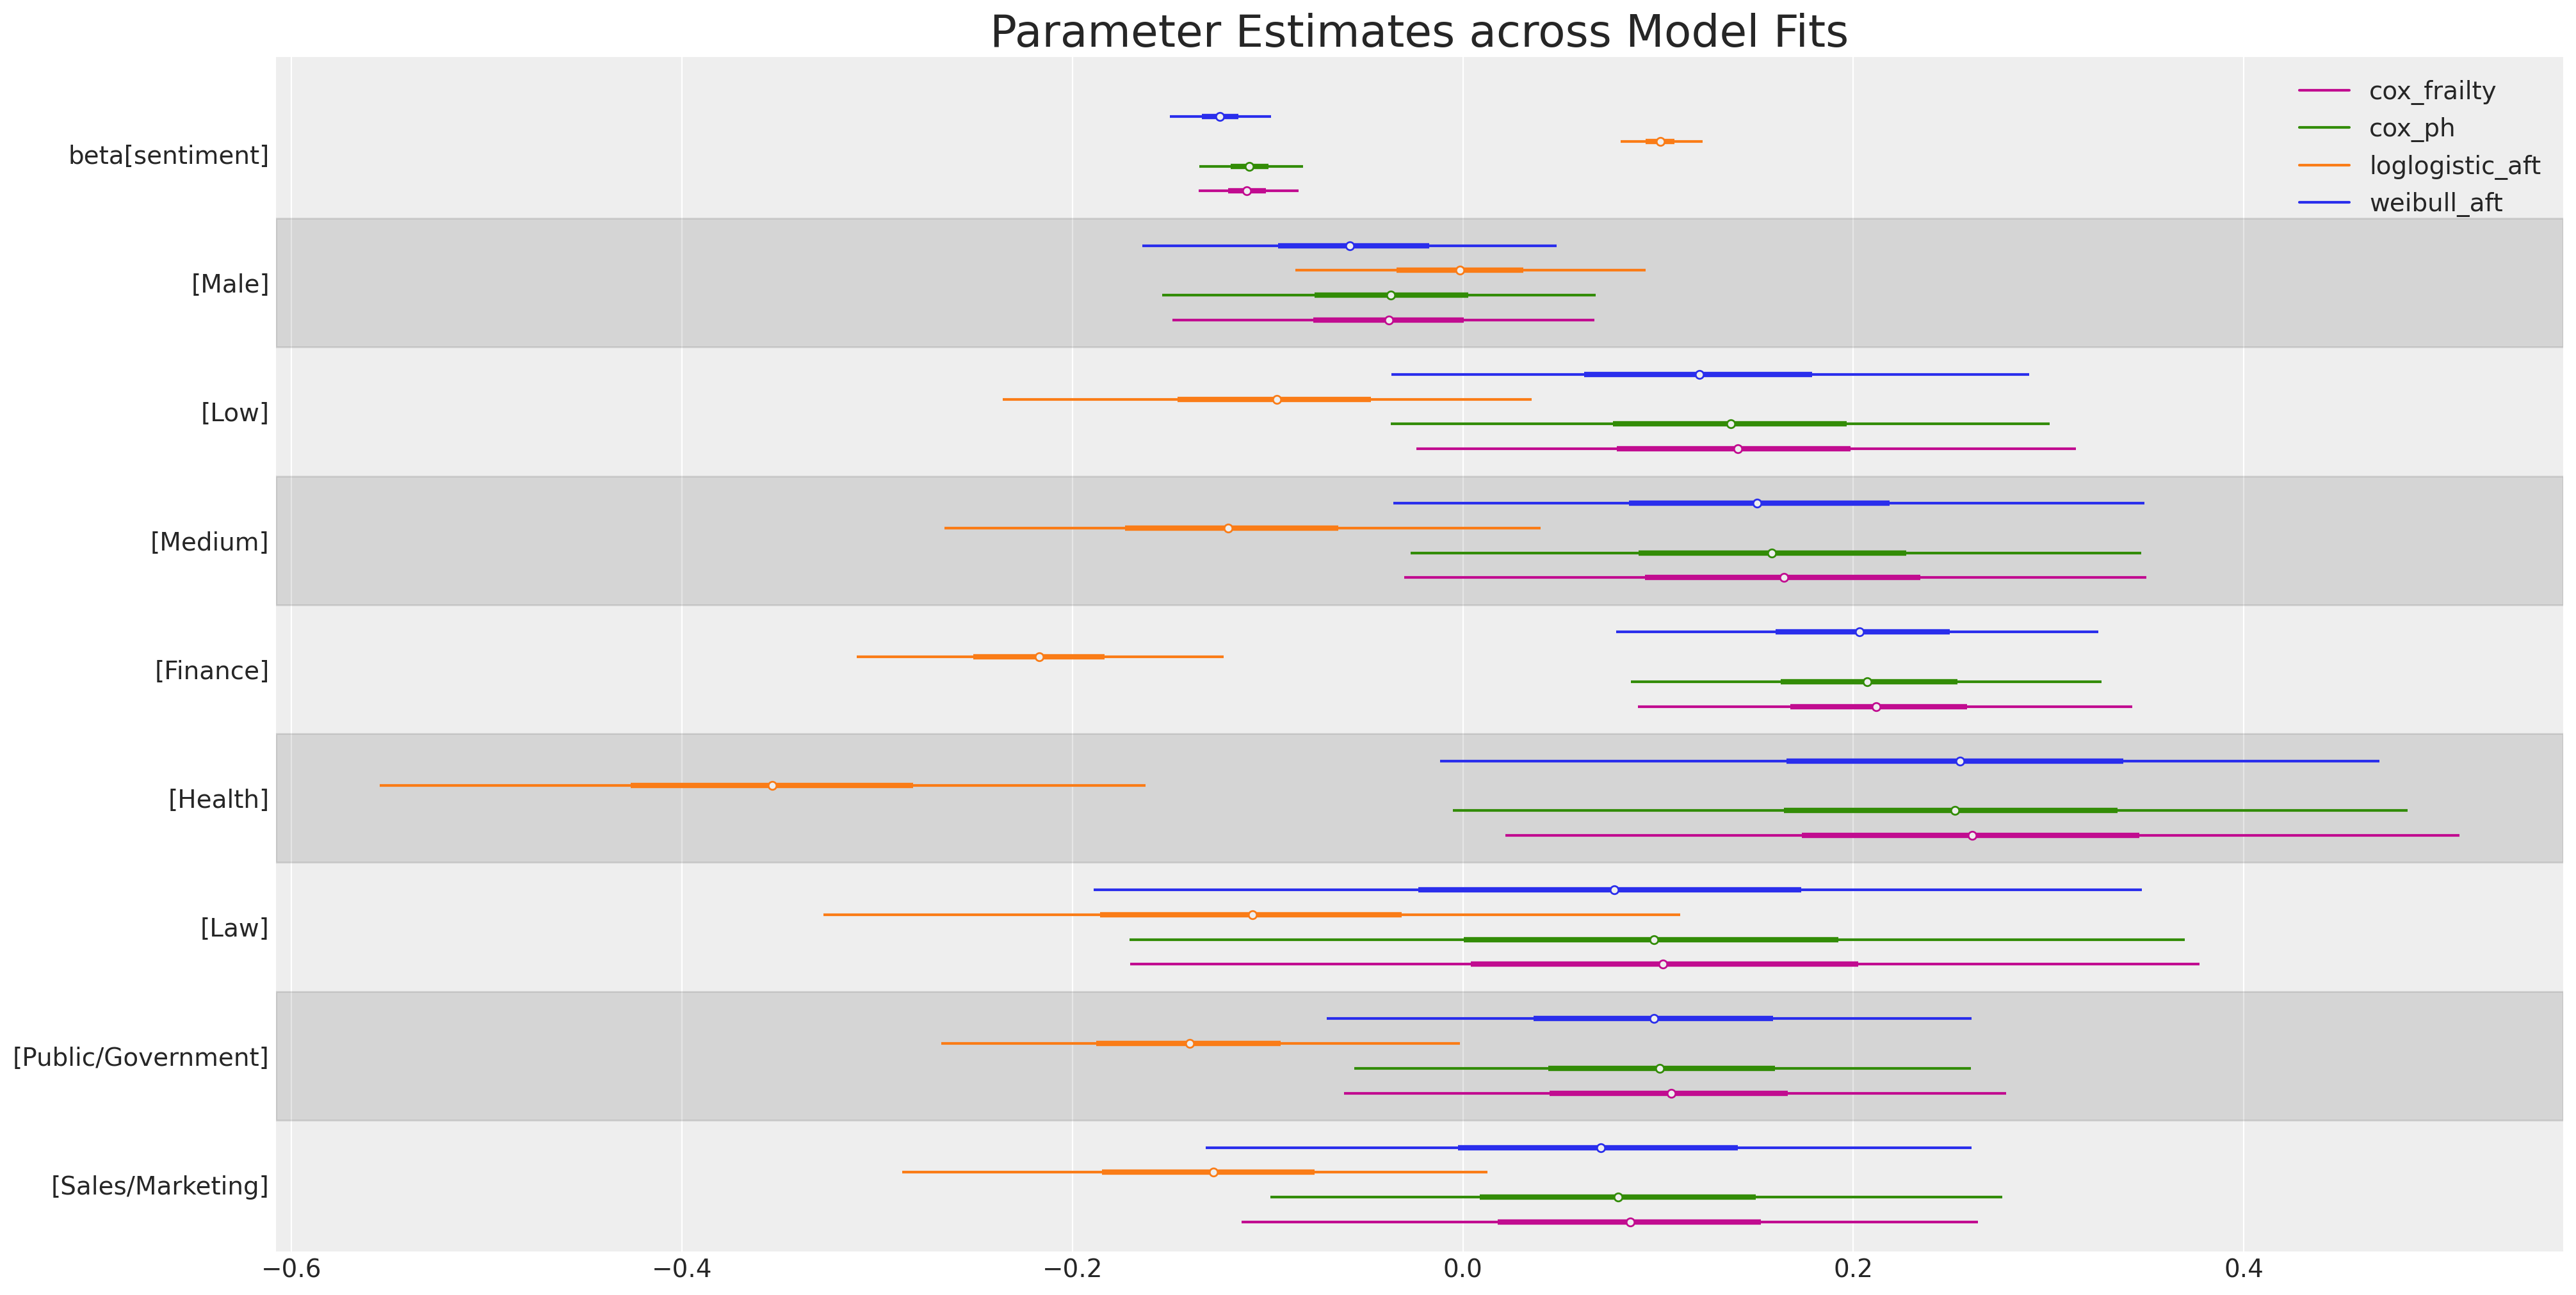

In [729]:
ax = az.plot_forest([weibull_idata, loglogistic_idata, base_idata, frailty_idata], model_names=['weibull_aft', 'loglogistic_aft', 'cox_ph', 'cox_frailty'],
               var_names=['beta'], combined=True, figsize=(20, 10), ridgeplot_alpha=0.5)
ax[0].set_title("Parameter Estimates across Model Fits", fontsize=25);

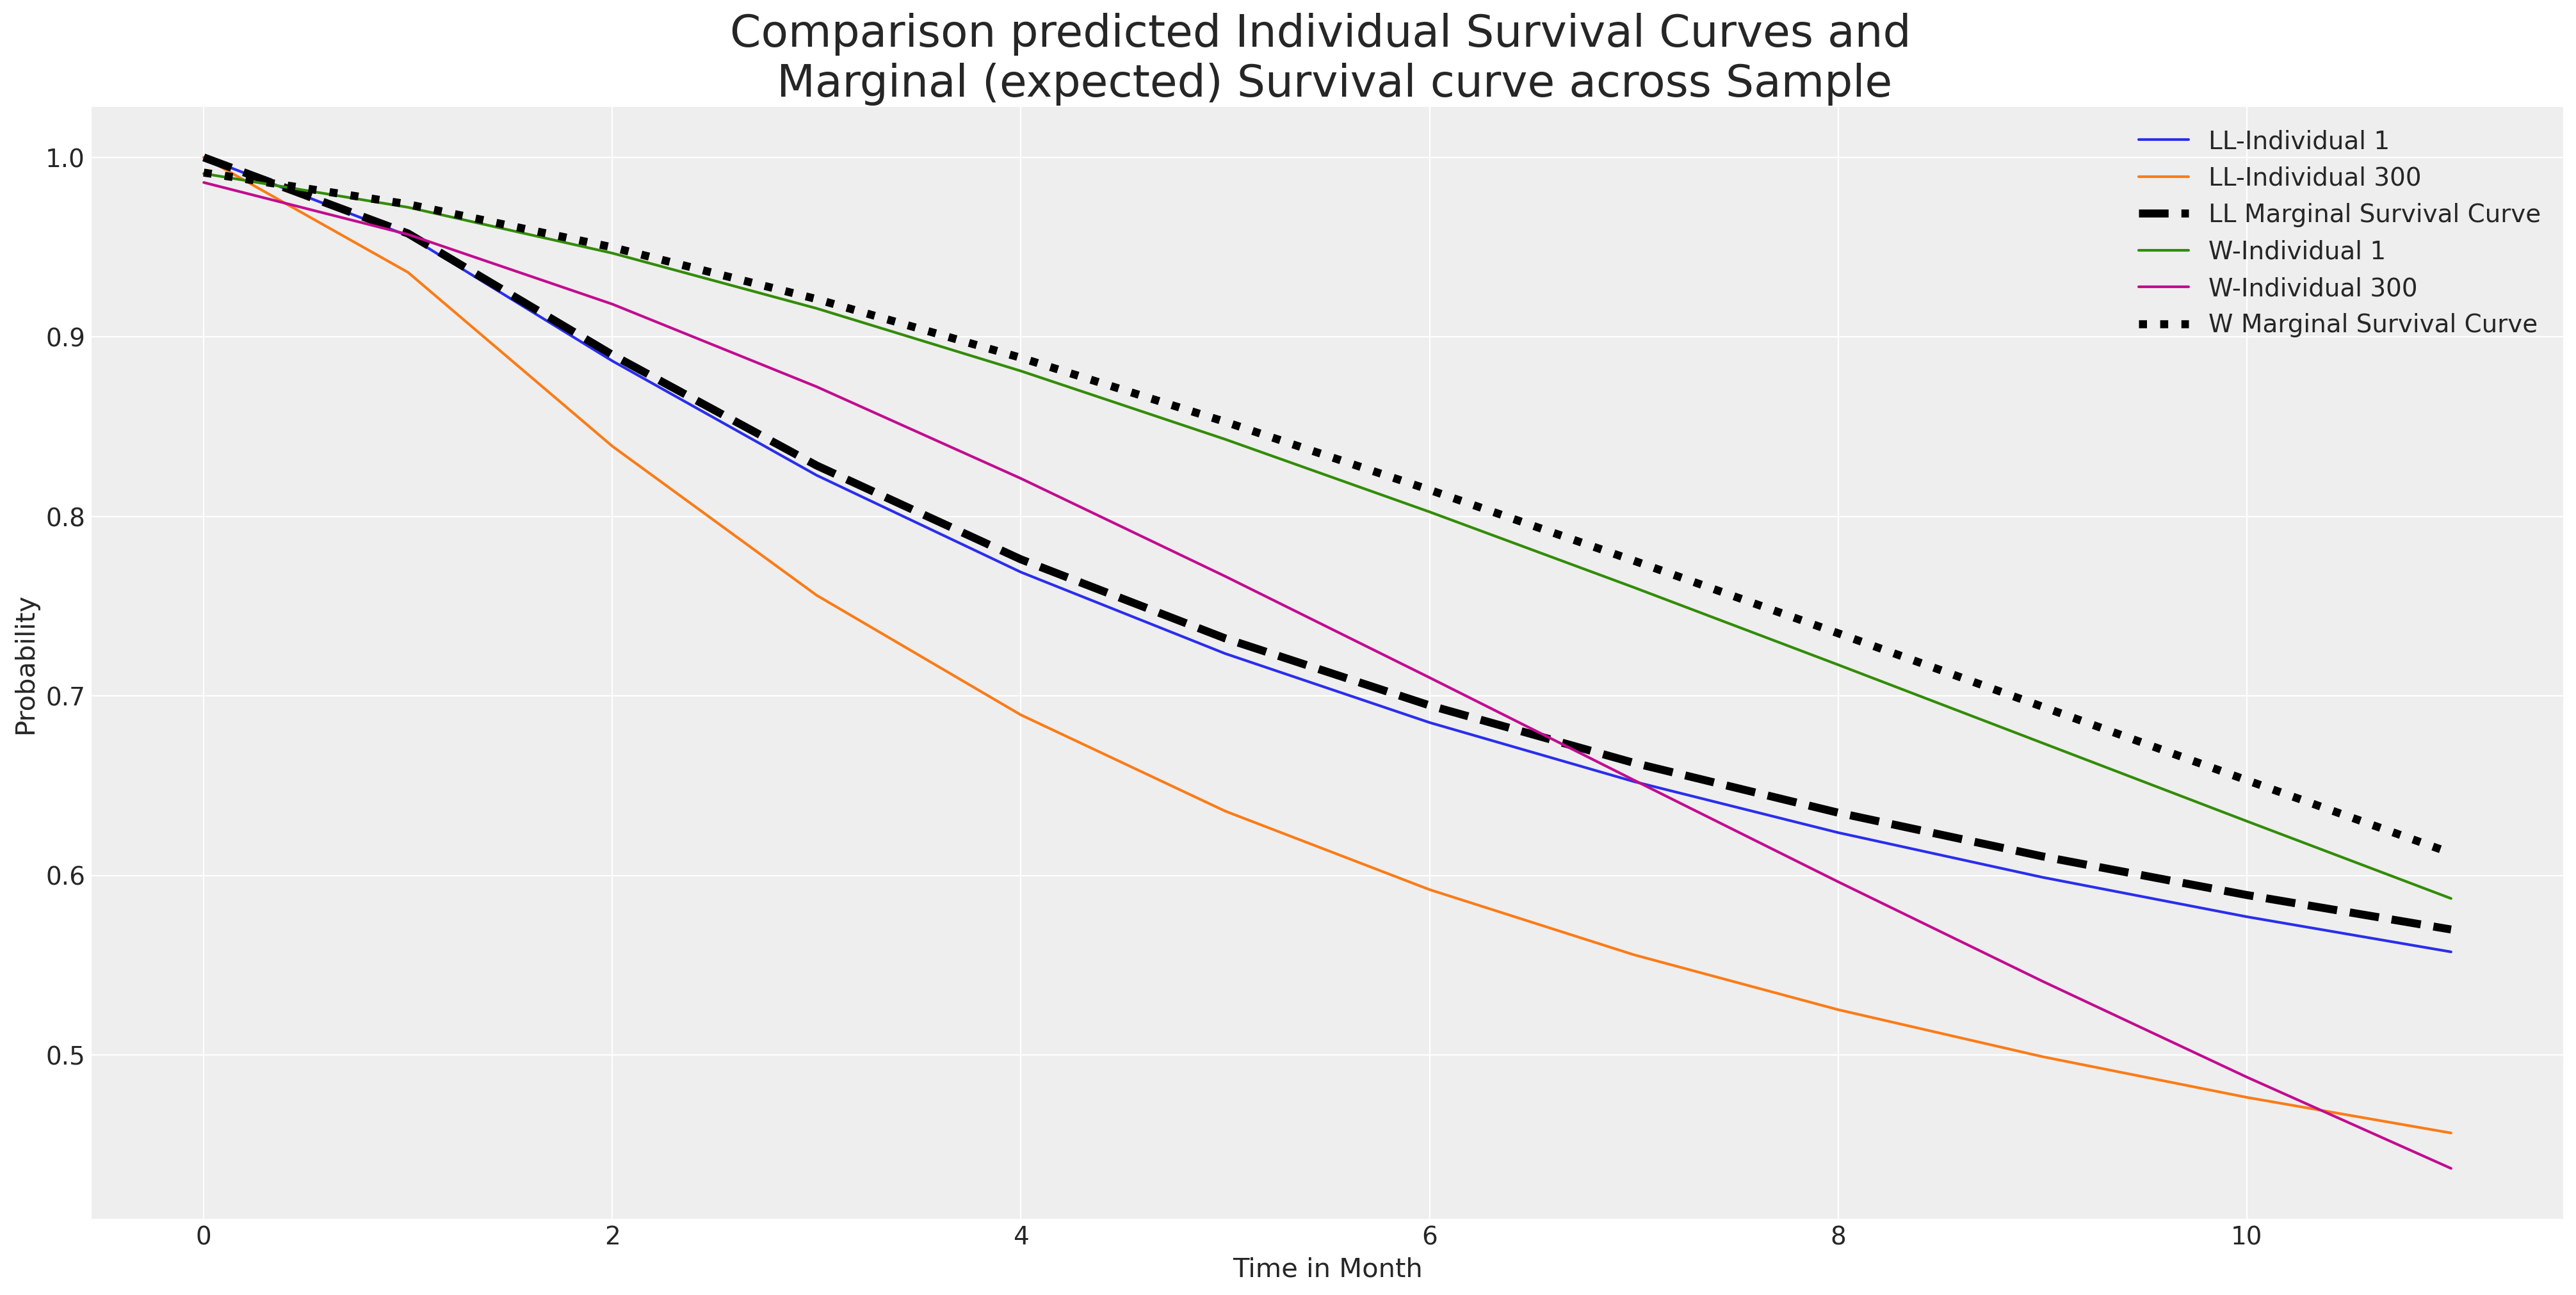

In [703]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(loglogistic_predicted_surv.iloc[:, [1, 300]], label = ['LL-Individual 1', 'LL-Individual 300'])
ax.plot(loglogistic_predicted_surv.mean(axis=1), label = 'LL Marginal Survival Curve', linestyle='--', color='black',  linewidth=4.5)
ax.plot(weibull_predicted_surv.iloc[:, [1, 300]], label = ['W-Individual 1', 'W-Individual 300'])
ax.plot(weibull_predicted_surv.mean(axis=1), label = 'W Marginal Survival Curve', linestyle='dotted', color='black', linewidth=4.5)
ax.set_title("Comparison predicted Individual Survival Curves and \n Marginal (expected) Survival curve across Sample", fontsize=25)
ax.set_xlabel("Time in Month")
ax.set_ylabel("Probability")
ax.legend();

## Interrogating the Cox Frailty Model


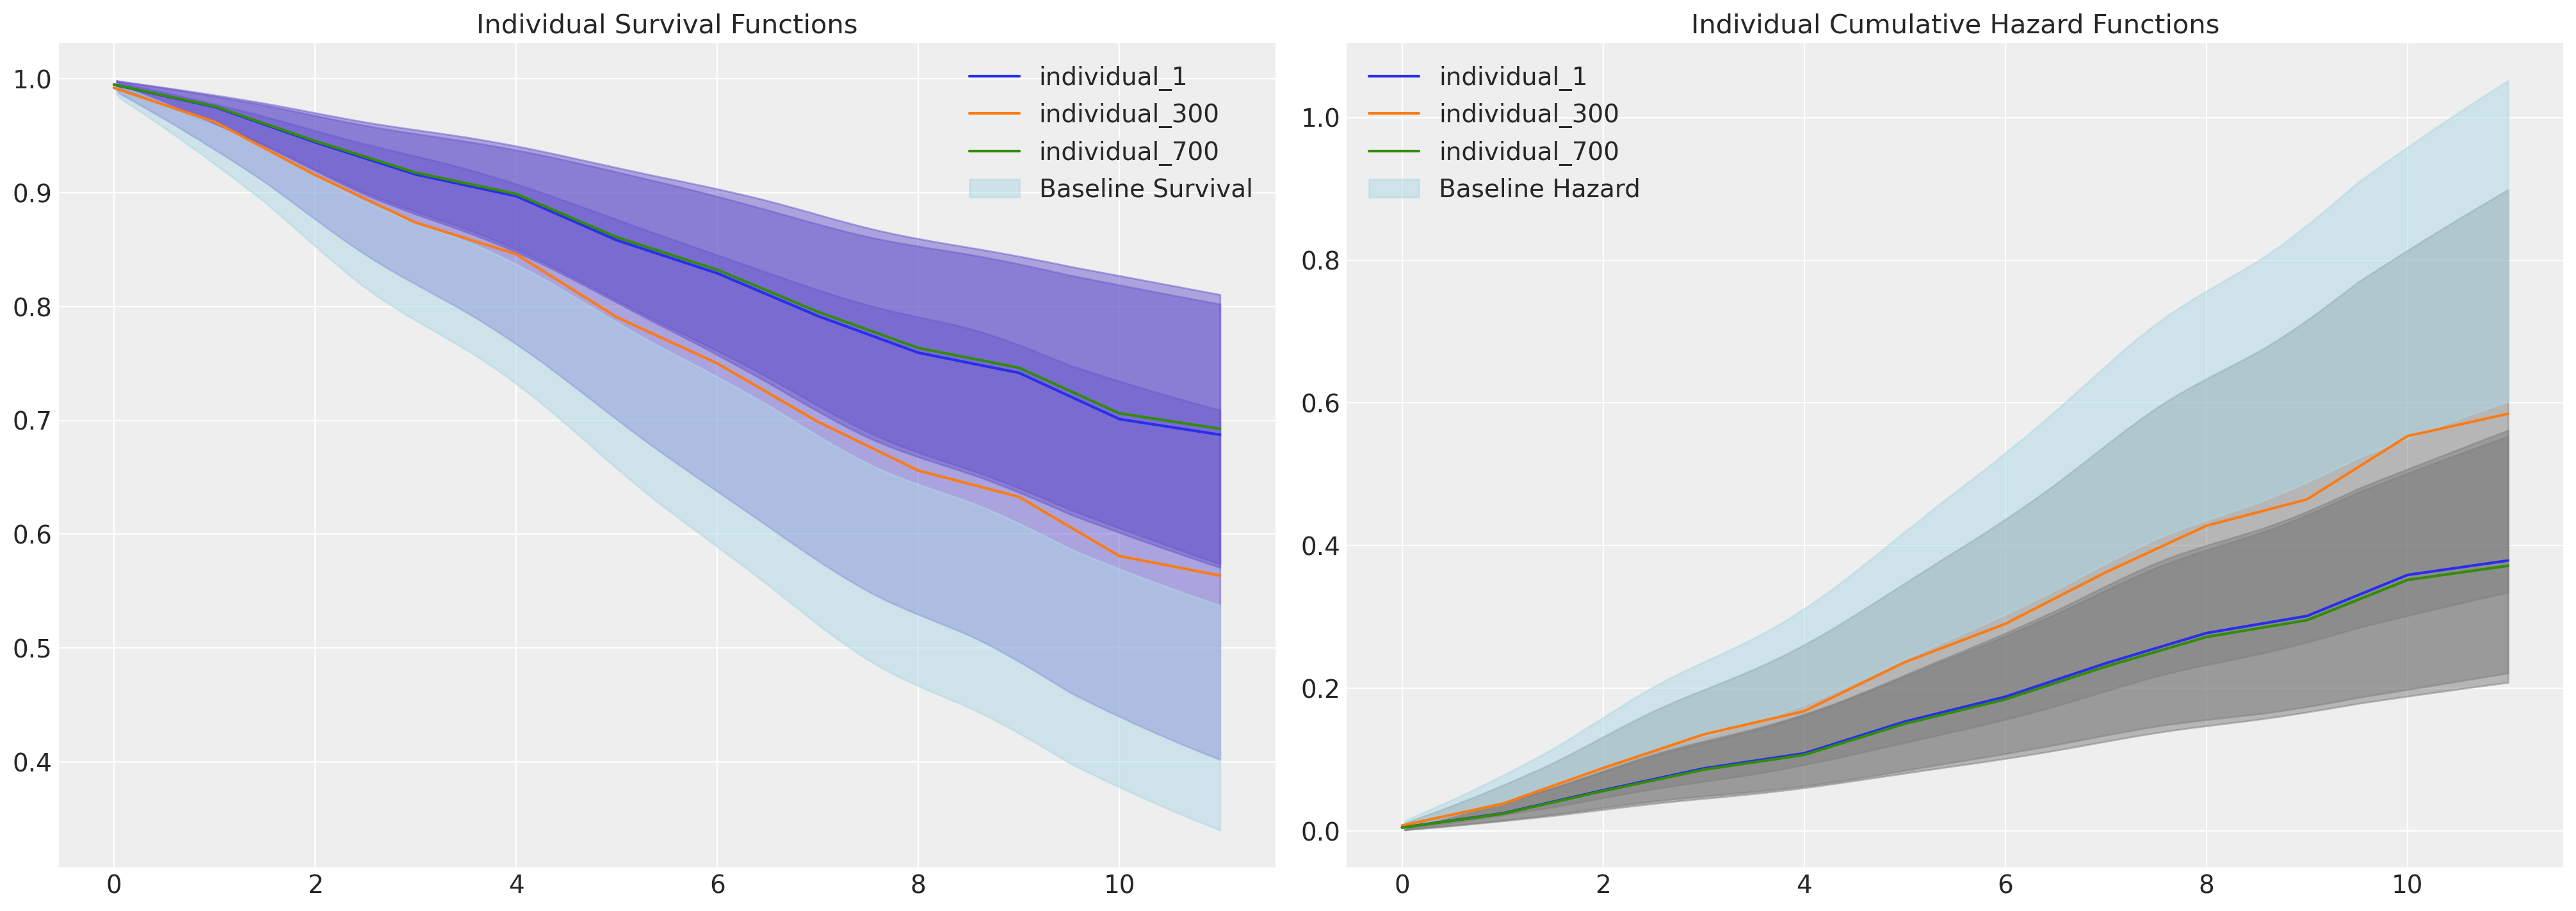

In [822]:
def extract_individual_frailty(i, retention_df):
    hazard_base = frailty_idata['posterior']['lambda0']
    beta = frailty_idata.posterior['beta']
    frailty = frailty_idata.posterior['frailty']
    full_hazard_idata = frailty.sel(frailty_id=i)*(hazard_base * np.exp( 
                                        beta.sel(preds='sentiment')*retention_df.iloc[i]['sentiment'] + 
                                        beta.sel(preds='Male')*retention_df.iloc[i]['Male'] +
                                        beta.sel(preds='Low')*retention_df.iloc[i]['Low'] +  
                                        beta.sel(preds='Medium')*retention_df.iloc[i]['Medium'] 
                                        ))

    cum_haz_idata = cum_hazard(full_hazard_idata)
    survival_idata = survival(full_hazard_idata)
    return full_hazard_idata, cum_haz_idata, survival_idata, hazard_base

def plot_individual_frailty(retention_df, individuals=[1, 300, 700]): 
    fig, axs = plt.subplots(1, 2, figsize=(20, 7))
    axs = axs.flatten()
    for i in individuals:
        haz_idata, cum_haz_idata, survival_idata, base_hazard = extract_individual_frailty(i, retention_df)
        axs[0].plot(get_mean(survival_idata), label=f'individual_{i}')
        az.plot_hdi(range(12),survival_idata, ax=axs[0], fill_kwargs={'color': 'slateblue'})
        axs[1].plot(get_mean(cum_haz_idata), label=f'individual_{i}')
        az.plot_hdi(range(12),cum_haz_idata, ax=axs[1], fill_kwargs={'color': 'grey'})
        axs[0].set_title("Individual Survival Functions", fontsize=15)
        axs[1].set_title("Individual Cumulative Hazard Functions", fontsize=15)
    az.plot_hdi(range(12), survival(base_hazard), color='lightblue', ax=axs[0], fill_kwargs={"label": "Baseline Survival"})
    az.plot_hdi(range(12), cum_hazard(base_hazard), color='lightblue', ax=axs[1], fill_kwargs={"label": "Baseline Hazard"})
    axs[0].legend()
    axs[1].legend()

plot_individual_frailty(retention_df)

In [824]:
def create_predictions(retention_df):
    cum_haz = {}
    surv = {}
    for i in range(len(retention_df)):
        haz_idata, cum_haz_idata, survival_idata, base_hazard = extract_individual_frailty(i, retention_df)
        cum_haz[i] = get_mean(cum_haz_idata)
        surv[i] = get_mean(survival_idata)
    cum_haz = pd.DataFrame(cum_haz)
    surv = pd.DataFrame(surv)
    return cum_haz, surv

cum_haz_frailty_df, surv_frailty_df = create_predictions(retention_df)
surv_frailty_df

0         1         2         3         4         5         6     \
0   0.991491  0.994750  0.993682  0.994903  0.994573  0.992622  0.994784   
1   0.960244  0.975296  0.970303  0.976012  0.974453  0.965344  0.975436   
2   0.911183  0.944224  0.933182  0.945821  0.942352  0.922314  0.944535   
3   0.867504  0.915959  0.899666  0.918341  0.913178  0.883730  0.916416   
4   0.838578  0.896907  0.877217  0.899795  0.893551  0.858004  0.897466   
5   0.781096  0.858203  0.831927  0.862105  0.853748  0.806502  0.858983   
6   0.739042  0.829152  0.798219  0.833766  0.823909  0.768467  0.830093   
7   0.686205  0.791608  0.755046  0.797126  0.785435  0.720201  0.792769   
8   0.642059  0.759348  0.718297  0.765572  0.752431  0.679502  0.760671   
9   0.618426  0.741699  0.698329  0.748303  0.734413  0.657545  0.743113   
10  0.565411  0.701067  0.652760  0.708478  0.692982  0.607864  0.702669   
11  0.547932  0.687345  0.637490  0.695003  0.678996  0.591332  0.688990   

        7         8         9     ...      3760      3761      3762      3763  \
0   0.994316  0.994626  0.994315  ...  0.993810  0.995644  0.991643  0.994354   
1   0.973250  0.974676  0.973236  ...  0.970882  0.979413  0.960886  0.973409   
2   0.939673  0.942835  0.939630  ...  0.934425  0.953404  0.912576  0.940015   
3   0.909238  0.913891  0.909161  ...  0.901471  0.929604  0.869505  0.909717   
4   0.888764  0.894404  0.888670  ...  0.879380  0.913486  0.840960  0.889324   
5   0.847297  0.854888  0.847200  ...  0.834797  0.880568  0.784195  0.848053   
6   0.816285  0.825245  0.816167  ...  0.801590  0.855687  0.742605  0.817162   
7   0.776360  0.787032  0.776245  ...  0.759029  0.823325  0.690219  0.777413   
8   0.742183  0.754233  0.742058  ...  0.722752  0.795275  0.646408  0.743351   
9   0.723544  0.736319  0.723411  ...  0.703042  0.779848  0.622932  0.724770   
10  0.680779  0.695122  0.680663  ...  0.657996  0.744098  0.570219  0.682143   
11  0.666371  0.681218  0.666258  ...  0.642874  0.731934  0.552810  0.667771   

        3764      3765      3766      3767      3768      3769  
0   0.994581  0.995739  0.993931  0.991613  0.996411  0.994905  
1   0.974512  0.979869  0.971479  0.960715  0.983012  0.975968  
2   0.942488  0.954431  0.935760  0.912208  0.961439  0.945681  
3   0.913395  0.931127  0.903428  0.868963  0.941605  0.918119  
4   0.893785  0.915340  0.881723  0.840289  0.928114  0.899520  
5   0.854049  0.883083  0.837898  0.783240  0.900447  0.861721  
6   0.824246  0.858680  0.805220  0.741462  0.879414  0.833314  
7   0.785816  0.826920  0.763291  0.688886  0.851869  0.796590  
8   0.752827  0.799375  0.727490  0.644913  0.827846  0.764963  
9   0.734812  0.784204  0.708019  0.621352  0.814574  0.747651  
10  0.693384  0.749026  0.663474  0.568445  0.783617  0.707771  
11  0.679397  0.737032  0.648506  0.550984  0.773019  0.694274  

[12 rows x 3770 columns]

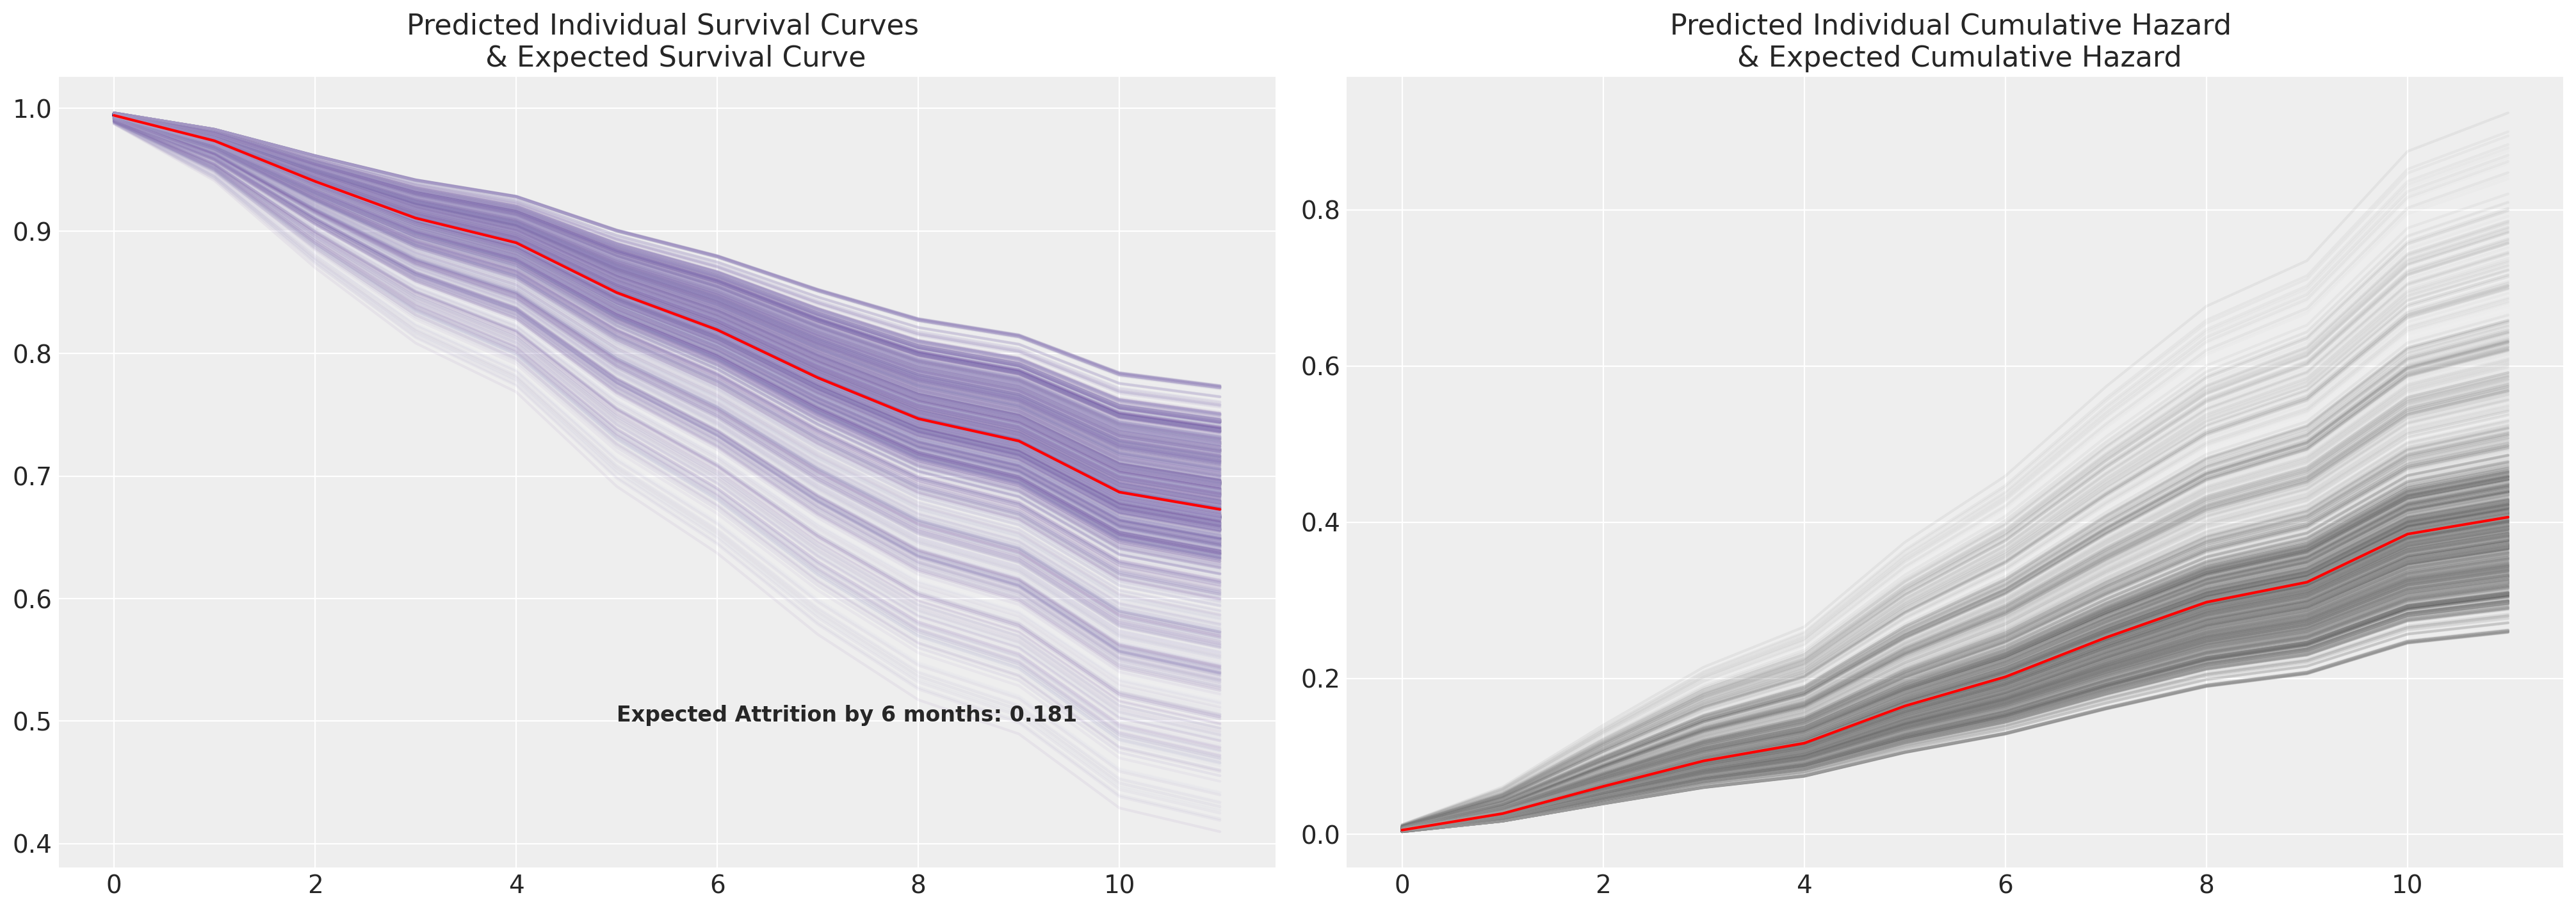

In [825]:
cm_subsection = np.linspace(0, 1, 120) 
colors_m = [cm.Purples(x) for x in cm_subsection]
colors = [cm.Greys(x) for x in cm_subsection]


fig, axs = plt.subplots(1, 2, figsize=(20, 7))
axs = axs.flatten()
cum_haz_frailty_df.plot(legend=False, color=colors, alpha=0.05, ax=axs[1])
axs[1].plot(cum_haz_frailty_df.mean(axis=1), color='red')
axs[1].set_title("Predicted Individual Cumulative Hazard \n & Expected Cumulative Hazard")

surv_frailty_df.plot(legend=False, color=colors_m, alpha=0.05, ax=axs[0])
axs[0].plot(surv_frailty_df.mean(axis=1), color='red');
axs[0].set_title("Predicted Individual Survival Curves \n  & Expected Survival Curve");
axs[0].annotate(f'Expected Attrition by 6 months: {np.round(1-surv_frailty_df.mean(axis=1).iloc[6], 3)}', (5, 0.5), 
                fontsize=12, fontweight='bold');

### Plotting the effects of the Frailty Terms

In [44]:
beta_individual = frailty_idata["posterior"]["frailty"]
beta_individual = beta_individual.sel(frailty_id=range(120))
predicted = beta_individual.mean(("chain", "draw"))
predicted = predicted.sortby(predicted)
ci_lb = beta_individual.quantile(0.025, ("chain", "draw")).sortby(predicted)
ci_ub = beta_individual.quantile(0.975, ("chain", "draw")).sortby(predicted)
hdi = az.hdi(beta_individual, hdi_prob=0.5).sortby(predicted)
hdi2 = az.hdi(beta_individual, hdi_prob=0.85).sortby(predicted)

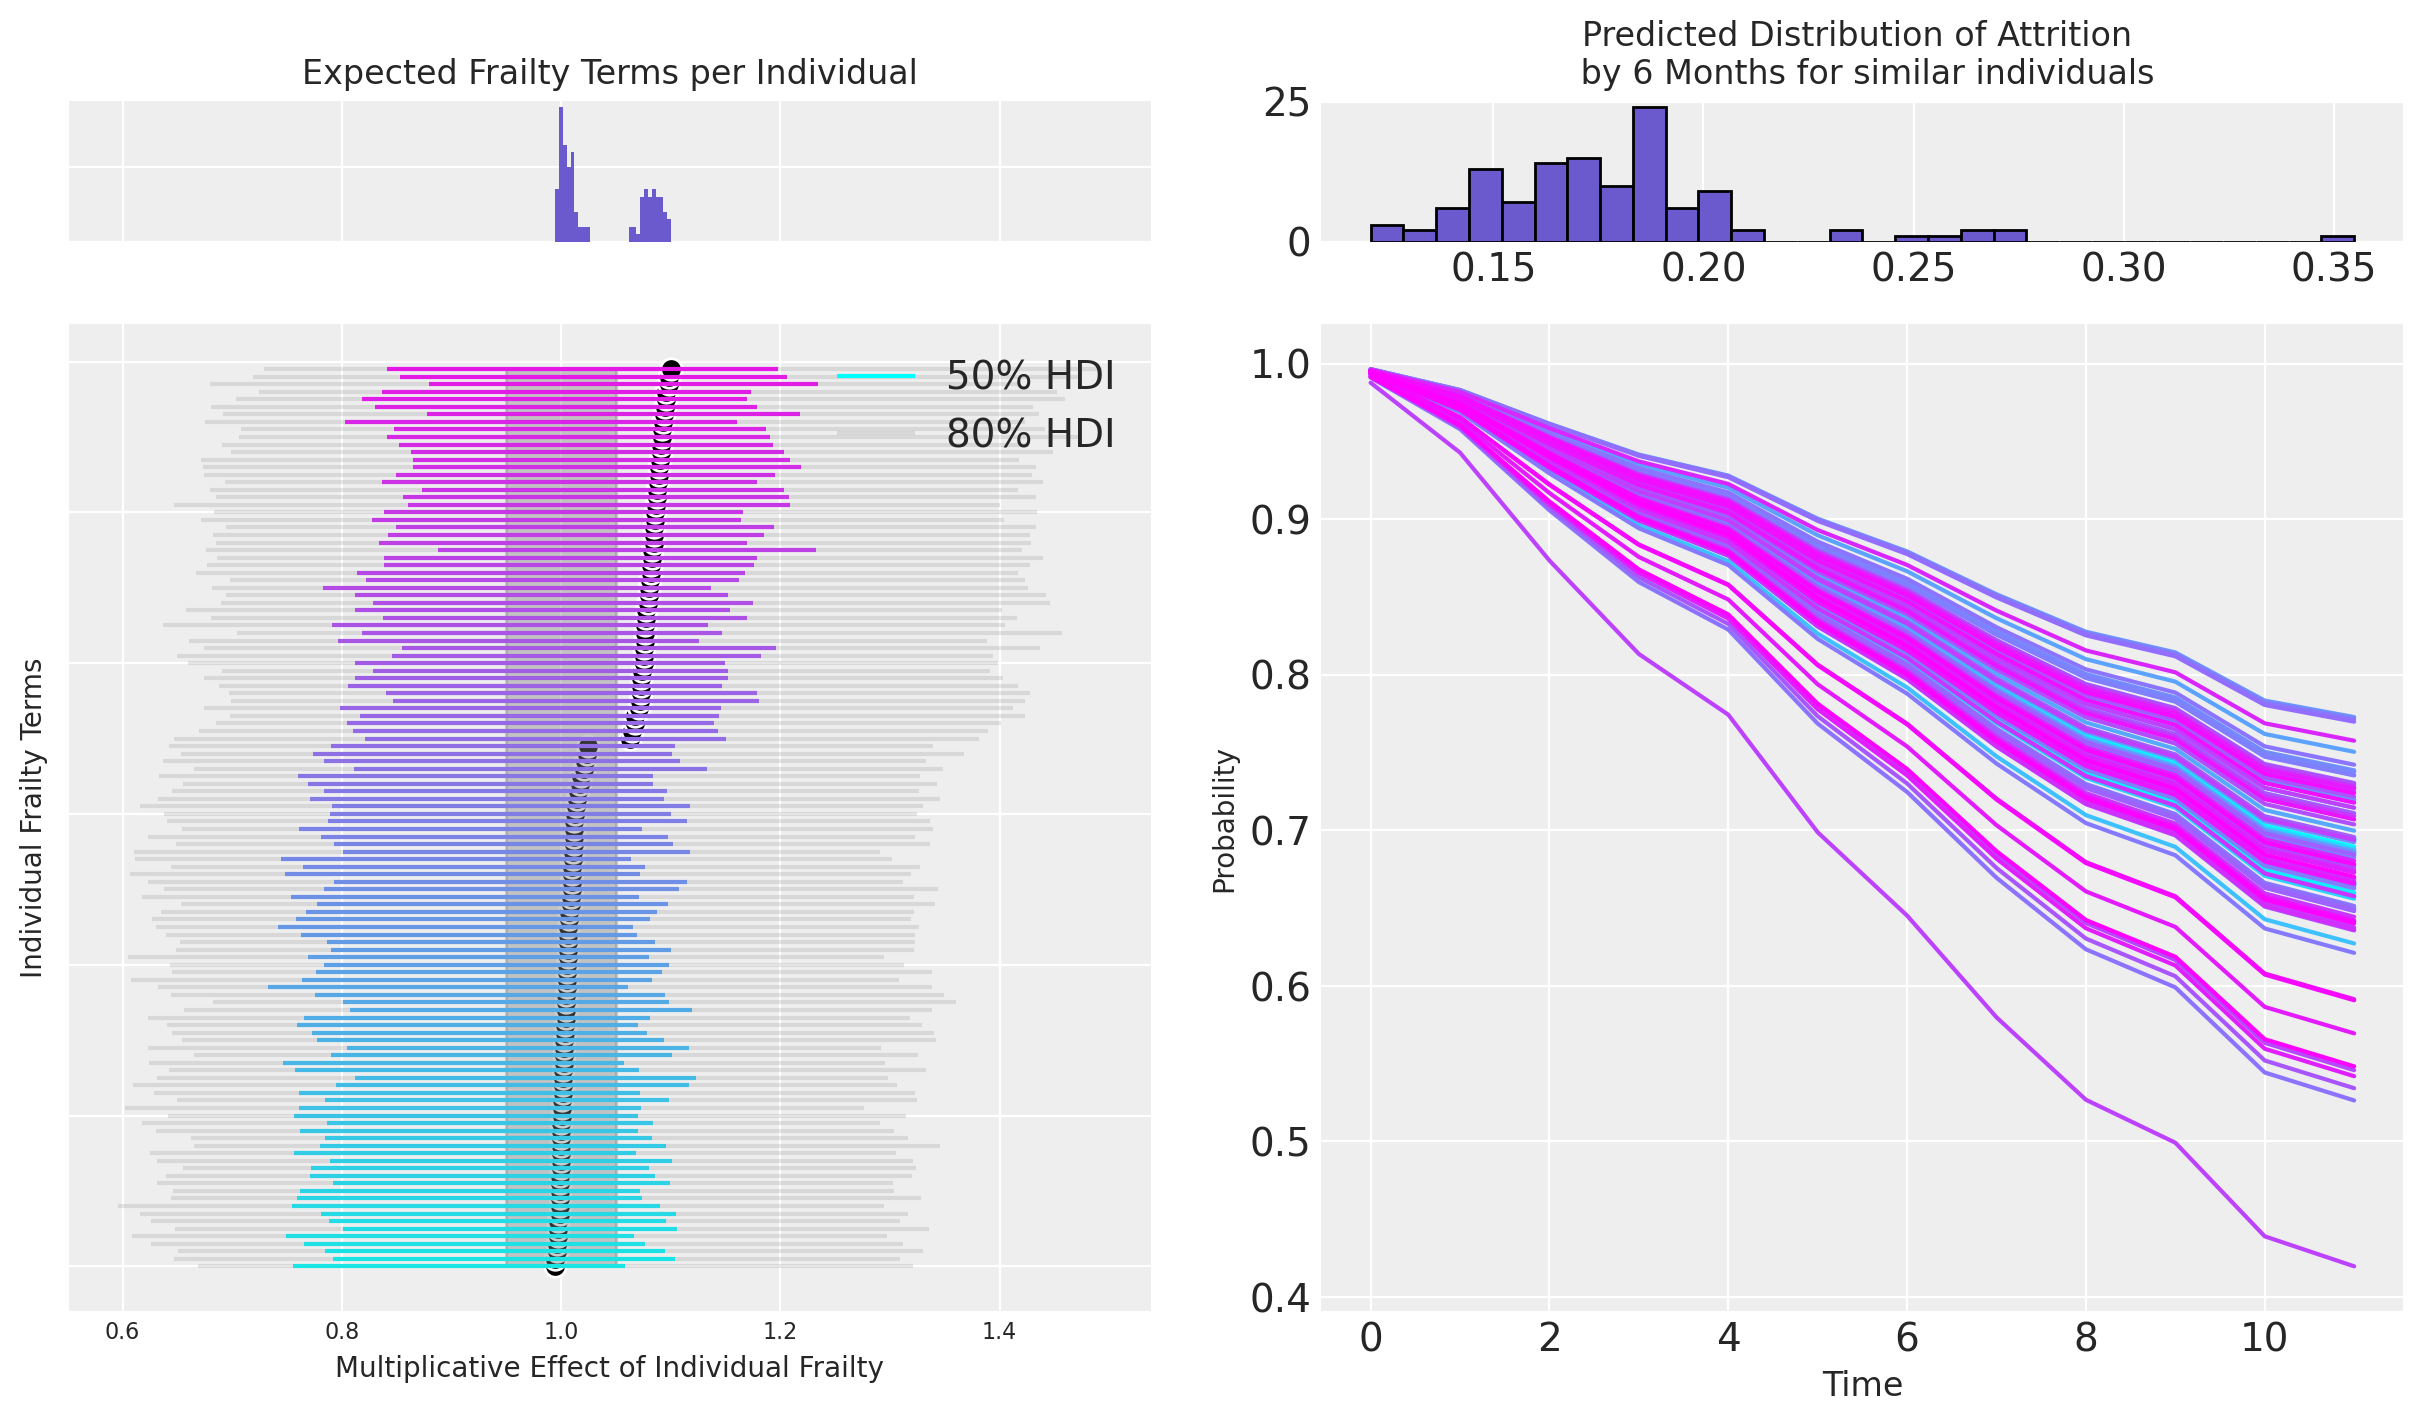

In [47]:
cm_subsection = np.linspace(0, 1, 120) 
colors = [cm.cool(x) for x in cm_subsection]

fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(
    2,
    2,
    height_ratios=(1, 7),
    left=0.1,
    right=0.9,
    bottom=0.1,
    top=0.9,
    wspace=0.05,
    hspace=0.05,
)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax.set_yticklabels([])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histx.set_title("Expected Frailty Terms per Individual", fontsize=12)
ax_histx.hist(predicted, bins=30, color='slateblue')
ax_histx.set_yticklabels([])
ax_histx.tick_params(labelsize=8)
ax.set_ylabel("Individual Frailty Terms", fontsize=10)
ax.tick_params(labelsize=8)
ax.hlines(
    range(len(predicted)),
    hdi.sel(hdi='lower').to_array(),
    hdi.sel(hdi='higher').to_array(),
    color=colors,
    label='50% HDI'
)
ax.hlines(
    range(len(predicted)),
    hdi2.sel(hdi='lower').to_array(),
    hdi2.sel(hdi='higher').to_array(),
    color='grey',
    alpha=0.2, 
    label='80% HDI'
)
ax.scatter(predicted, range(len(predicted)), color="black", ec="white", s=60)
ax.set_xlabel("Multiplicative Effect of Individual Frailty", fontsize=10)
ax.legend()
ax.fill_betweenx(range(len(predicted)), 0.95, 1.05, alpha=0.4, color="grey");

ax1 = fig.add_subplot(gs[1, 1])
surv_frailty_df[list(predicted['frailty_id'].values)].plot(ax=ax1, legend=False, color=colors);
ax1_hist = fig.add_subplot(gs[0, 1])
ax1_hist.hist((1 - surv_frailty_df[list(predicted['frailty_id'].values)].iloc[6]), bins=30, color='slateblue', ec='black')
ax1.set_xlabel("Time", fontsize=12)
ax1_hist.set_title("Predicted Distribution of Attrition \n by 6 Months for similar individuals", fontsize=12);
ax1.set_ylabel('Probability', fontsize=10);


## Authors
- Authored by [Nathaniel Forde](https://nathanielf.github.io/) in July 2023 

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [4]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Wed Jun 21 2023

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.11.0

pytensor: 2.11.1

numpy     : 1.23.5
matplotlib: 3.7.1
pandas    : 1.5.3
pymc      : 5.3.0
arviz     : 0.15.1

Watermark: 2.3.1



:::{include} ../page_footer.md
:::